In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from tqdm import tqdm

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import itertools
from scipy.optimize import minimize
from functools import partial
import random, os

Train labels are right, train sets are reversed

In [3]:
pre_train = np.load('/kaggle/input/preproceesed-data-375/pre_train_375.npy')
pre_test = np.load('/kaggle/input/preproceesed-data-375/pre_test_375.npy')
test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
                           index_col='planet_id')
train_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_adc_info.csv',
                           index_col='planet_id')
axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2024/axis_info.parquet')
train_label = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_labels.csv')
pre_train = pre_train[:, :, ::-1]
pre_test = pre_test[:, :, ::-1]

@ time point 0 observed wls

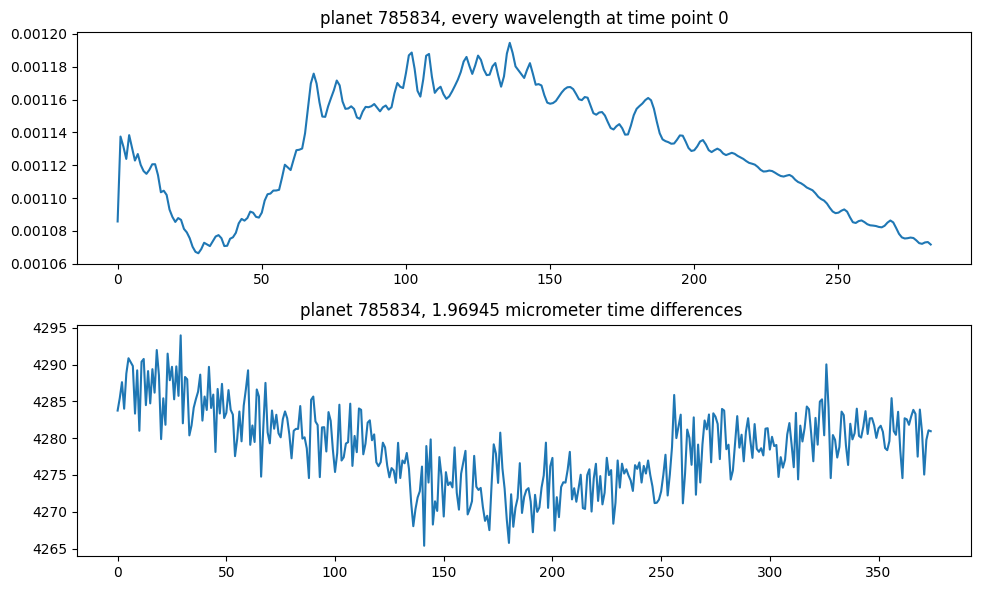

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
axes[0].plot(np.arange(283), train_label.iloc[0][1:], '-')
axes[0].set_title('planet 785834, every wavelength at time point 0')
axes[1].plot(np.arange(375), np.transpose(pre_train, (0,2,1))[0][3], '-')
axes[1].set_title('planet 785834, 1.96945 micrometer time differences ')
plt.tight_layout()
plt.show()

In [5]:
def phase_detector(signal):
    phase1, phase2 = None, None
    best_drop = 0
    for i in range(50,150):        
        t1 = signal[i:i+20].max() - signal[i:i+20].min()
        if t1 > best_drop:
            phase1 = i+20+5
            best_drop = t1
    
    best_drop = 0
    for i in range(200,300):
        t1 = signal[i:i+20].max() - signal[i:i+20].min()
        if t1 > best_drop:
            phase2 = i-5
            best_drop = t1
    
    return phase1, phase2

Split data into in transit, out of transit using phase p1, p2

In [6]:
train = pre_train.copy()
in_transit = []
out_of_transit= []
for i in range(len(train_adc_info)):
    p1,p2 = phase_detector(pre_train[i,:,1:].mean(axis=1))
    train[i] = (train[i] - pre_train[i,p1:p2].mean(axis=0)) / pre_train[i,list(range(p1-40)) + list(range(p2+40,375))].mean(axis=0) * 1000.0
    in_transit.append(train[i,p1:p2,:])
    out_of_transit.append([train[i,:p1, :]]+[train[i, p2:, :]])

In [7]:
test = pre_test.copy()
test_in_transit = []
test_out_of_transit= []
for i in range(len(test_adc_info)):
    p1,p2 = phase_detector(pre_test[i,:,1:].mean(axis=1))
    test[i] = (test[i] - pre_test[i,p1:p2].mean(axis=0)) / pre_test[i,list(range(p1-40)) + list(range(p2+40,375))].mean(axis=0) * 1000.0
    test_in_transit.append(test[i,p1:p2,:])
    test_out_of_transit.append([test[i,:p1, :]]+[test[i, p2:, :]])

In [8]:
print(out_of_transit[0][0].shape,out_of_transit[0][1].shape, in_transit[0].shape)

(135, 283) (131, 283) (109, 283)


It is assumed that no wavelength-dependent absorption by the planet’s atmosphere occurs outside of the transit.
Therefore, fluctuations across wavelengths in out-of-transit regions might be seen to be caused by baseline noise sources such as white noise or jitter noise, which affect the entire dataset uniformly.
Shouldn't the pre-transit and post-transit signals theoretically be identical? assuming no instrumental drift or astrophysical variability.

The white noise estimated from the out-of-transit region is assumed to be uniformly distributed across the entire dataset.
However, during the in-transit phase, the signal may contain additional stellar noises like black dots or stellar flares resulting 
Therefore, if we aim to estimate a global average spectrum, we should account for these differences by subtracting noise separately for each region (in-transit vs. out-of-transit).

Assuming predictions as Mean of means of each phase + offset 

/tmp/ipykernel_29/1432590469.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axhline(train_label.iloc[0][i+1], label='real mean')


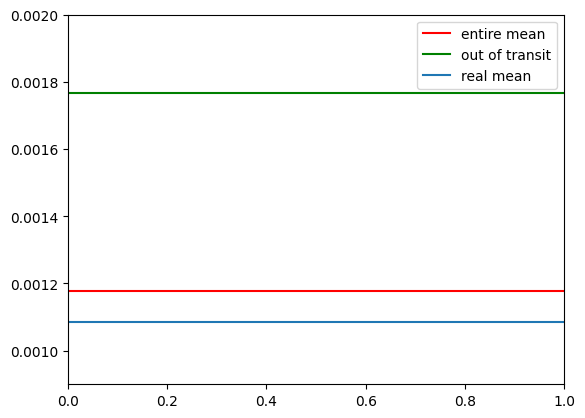

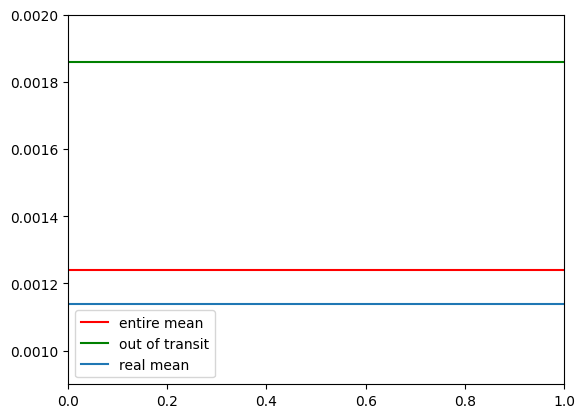

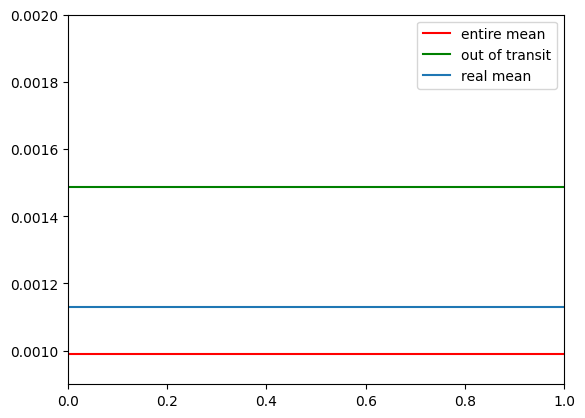

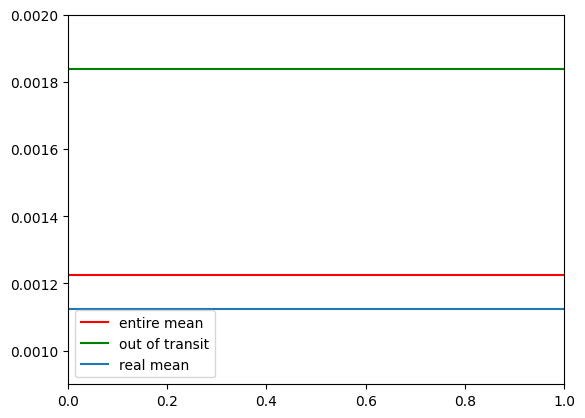

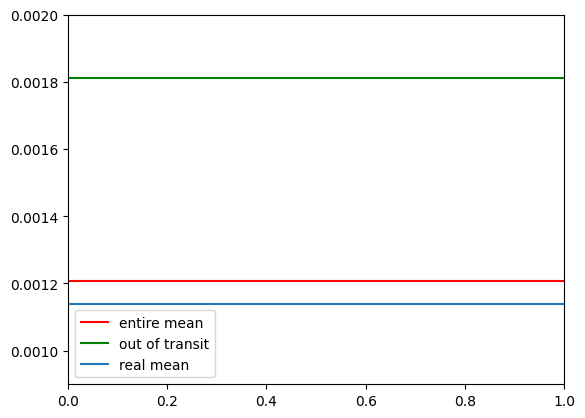

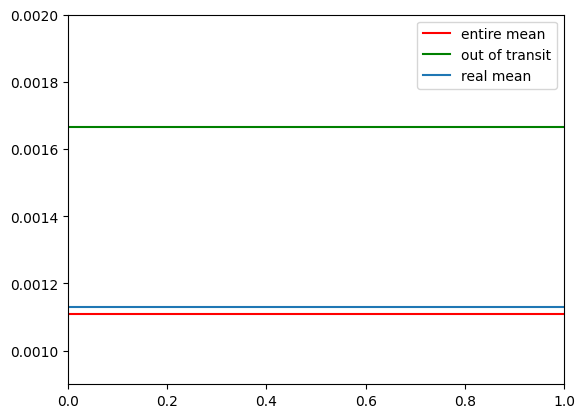

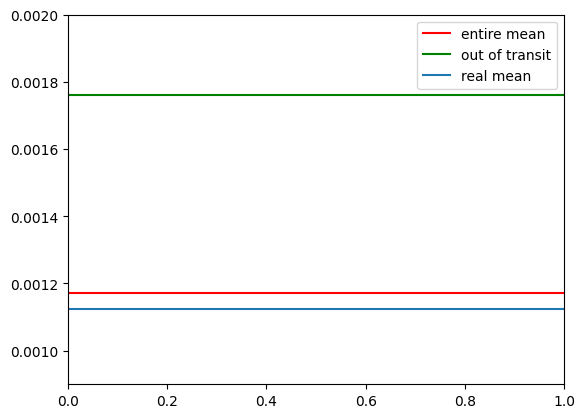

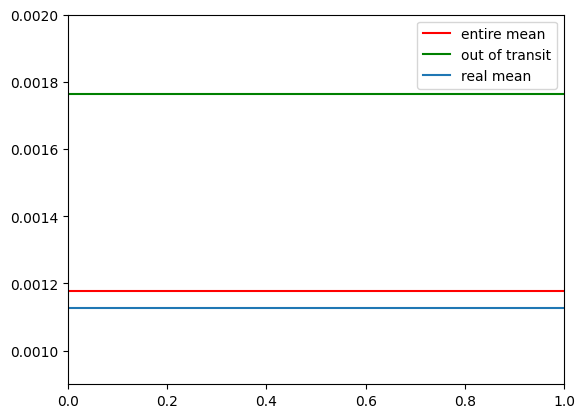

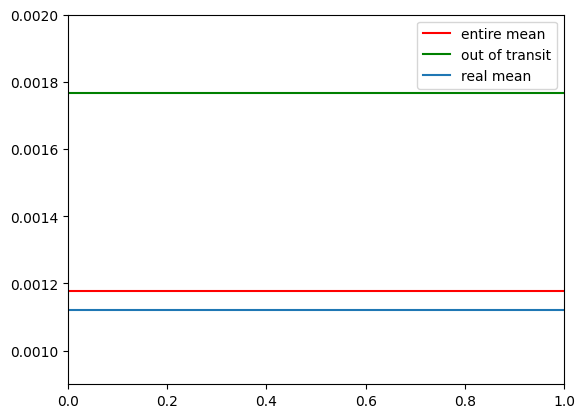

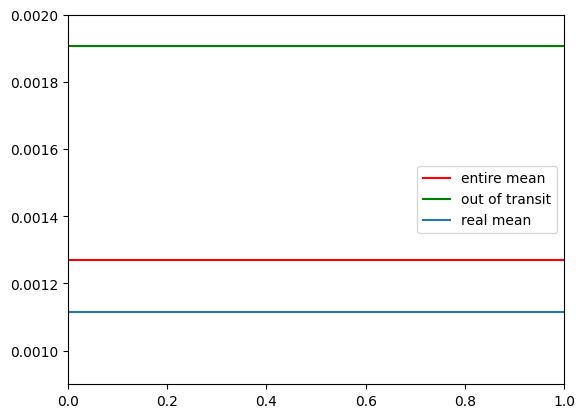

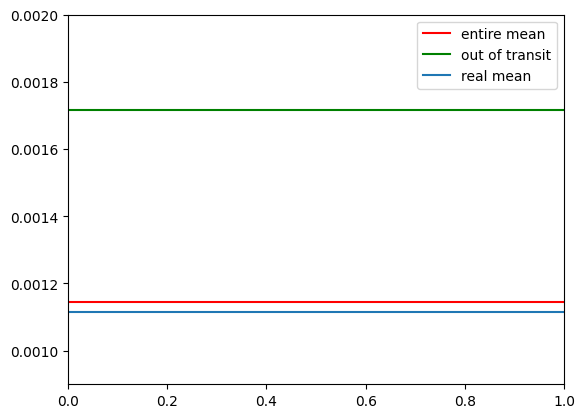

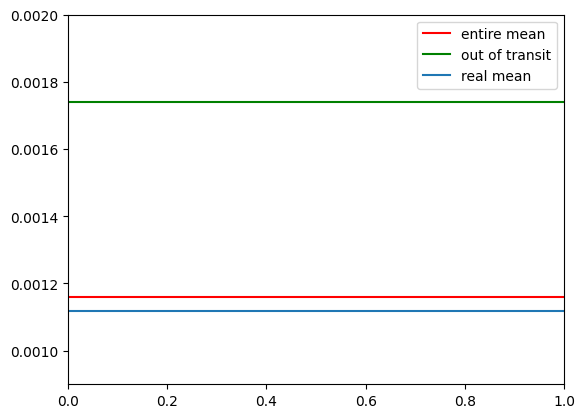

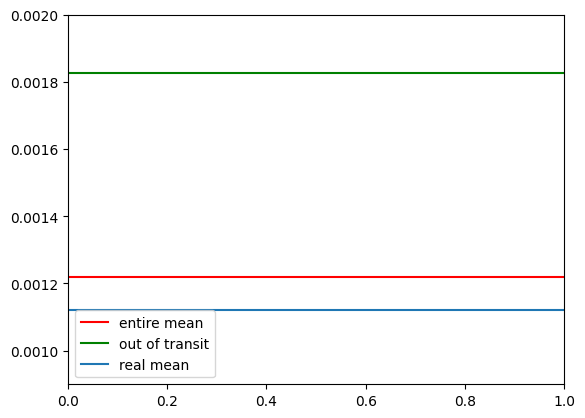

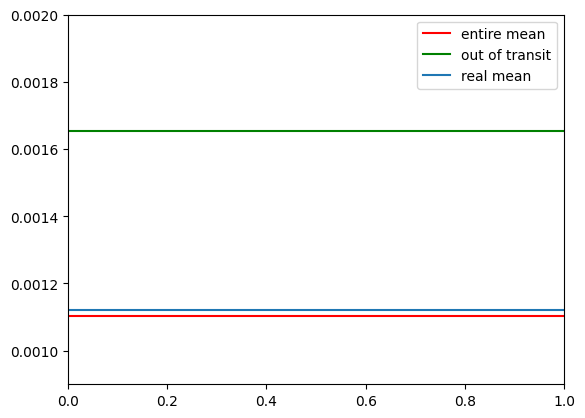

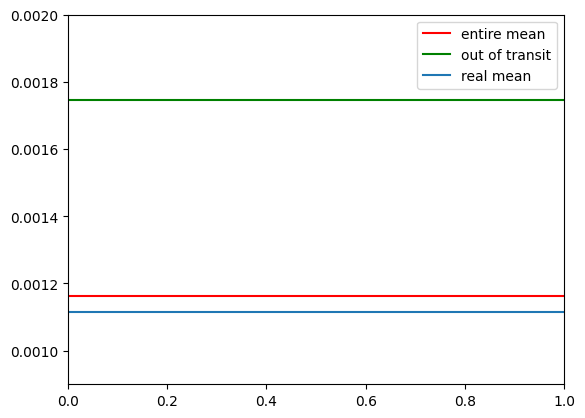

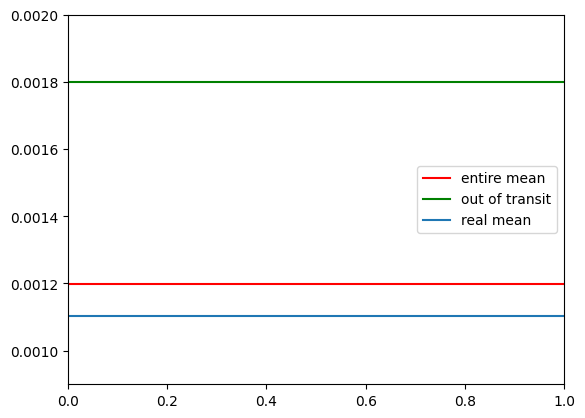

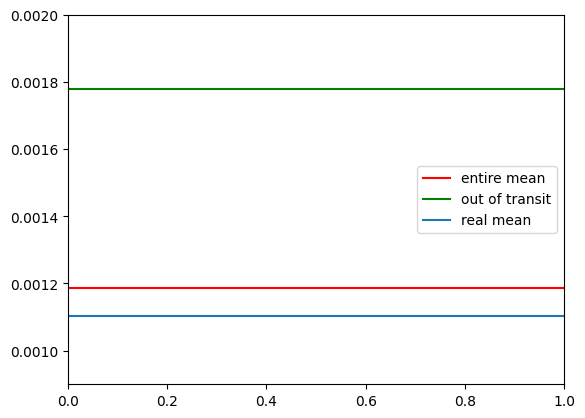

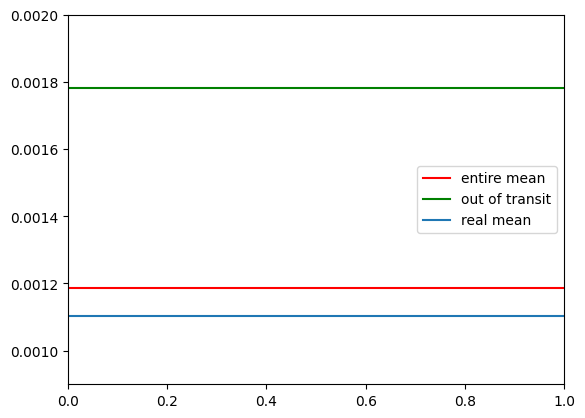

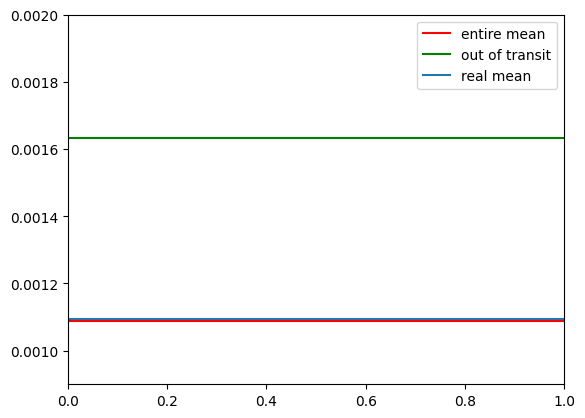

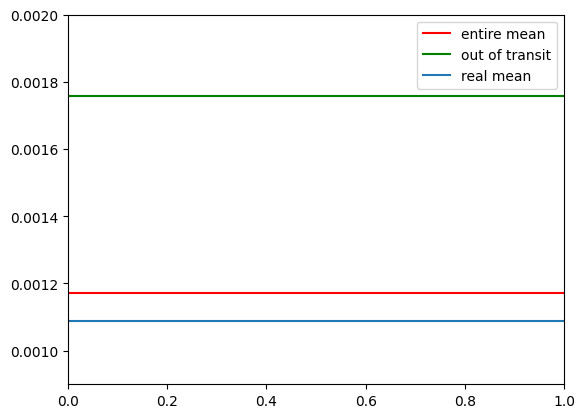

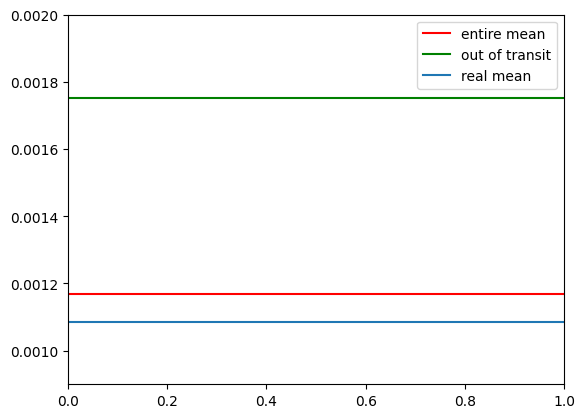

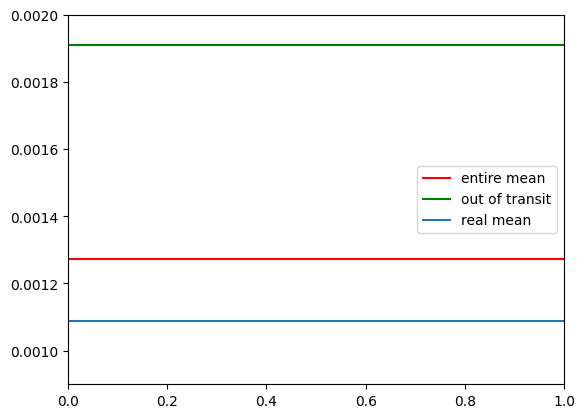

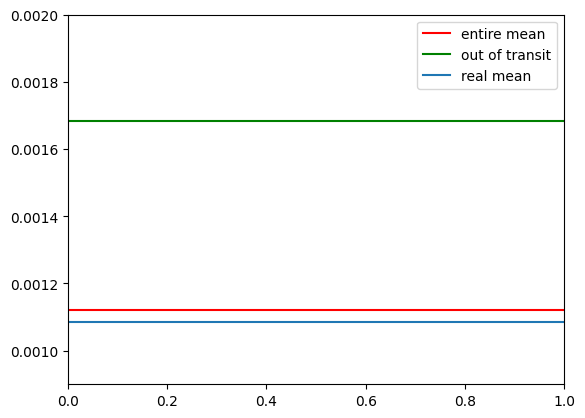

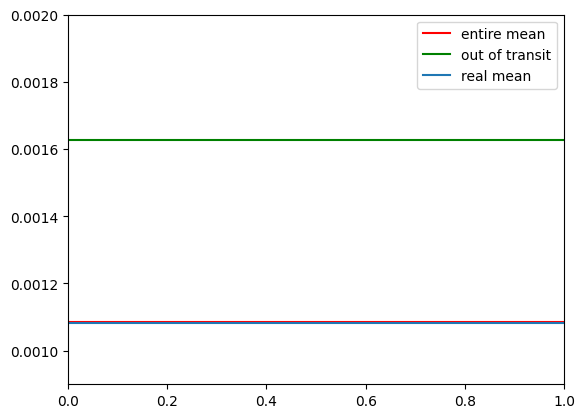

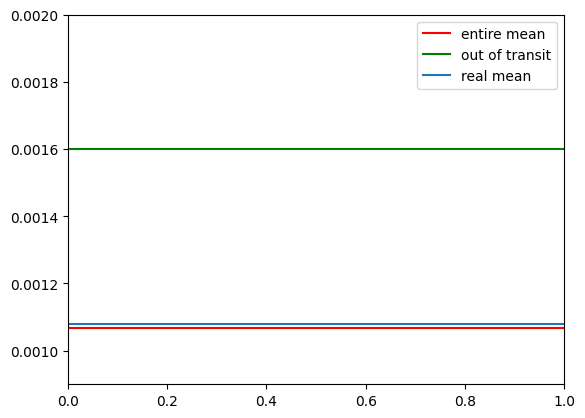

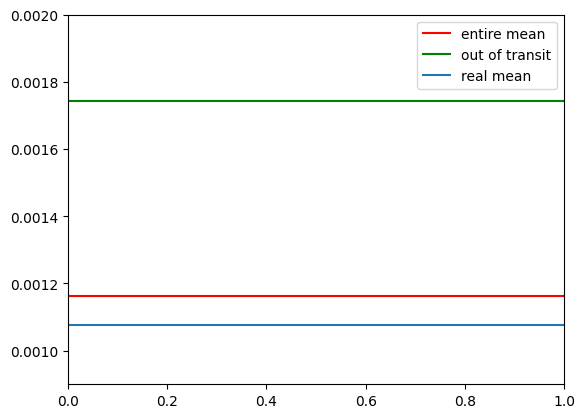

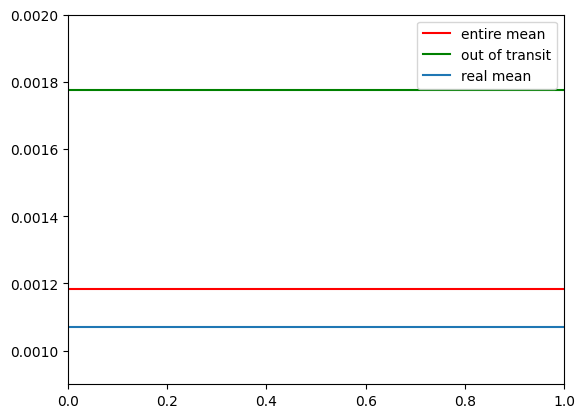

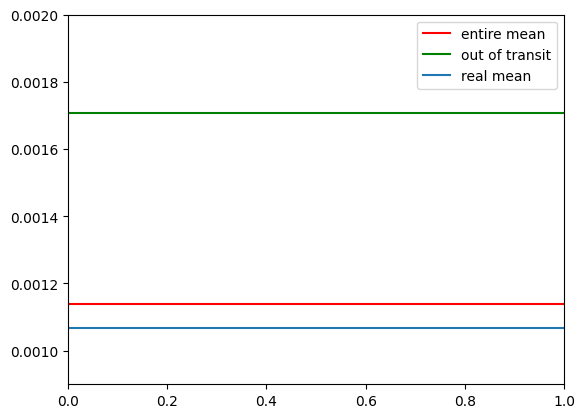

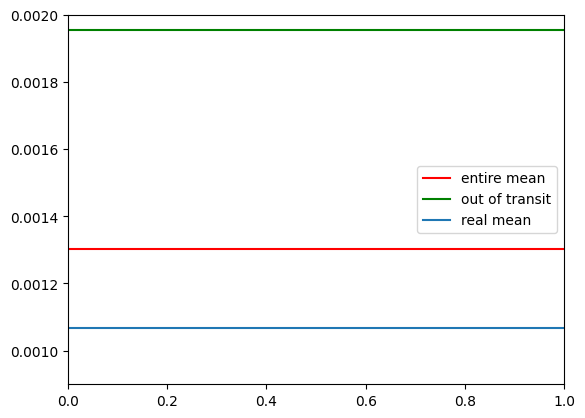

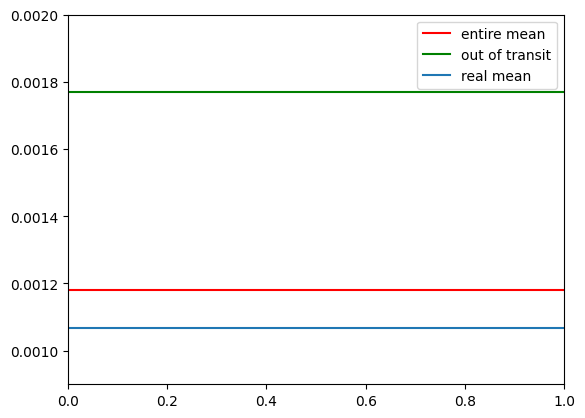

In [9]:
for i in range(30):
    mean_entire = (np.mean(np.transpose(out_of_transit[0][0], (1, 0))[i]) +
        np.mean(np.transpose(out_of_transit[0][1], (1, 0))[i]) +
        np.mean(np.transpose(in_transit[0], (1, 0))[i])) / 3
    mean_out_of_transit = (np.mean(np.transpose(out_of_transit[0][0], (1, 0))[i]) +
        np.mean(np.transpose(out_of_transit[0][1], (1, 0))[i])) / 2
    plt.axhline(mean_entire/1000, c='r' , label='entire mean')
    plt.axhline(mean_out_of_transit/1000, c='g', label='out of transit')
    plt.axhline(train_label.iloc[0][i+1], label='real mean')
    plt.ylim(0.0009,0.002)
    plt.legend(loc='best') 
    plt.show()

💡The overall mean and the true mean differ by less than 0.0001.

Result analysis

In [10]:
def classificator(column : str, value: int, data = train_adc_info):
    included_index_list = []
    excluded_index_list = []
    
    for i in range(len(data)):
        if data.iloc[i]['star'] == 1: included_index_list.append(i)
        else: excluded_index_list.append(i)
    return included_index_list, excluded_index_list
        

In [11]:
train_labels = np.array(train_label)
indexes, exdexes = classificator('star', 1)
solar_1_labels = train_labels[indexes]
solar_0_labels = train_labels[exdexes]

In [ ]:
uncertainty = np.zeros((len(train_adc_info), 566))
for i in range(len(train_adc_info)):
    preds = []
    target = train_label.iloc[i][1:]
    for j in range(283):
        preds.append((np.mean(np.transpose(out_of_transit[i][0], (1, 0))[j]) +
            np.mean(np.transpose(out_of_transit[i][1], (1, 0))[j]) +
            np.mean(np.transpose(in_transit[i], (1, 0))[j])) / 3 / 1000)
    if i in indexes: # solar 1
        preds_array = np.array(preds) + 0.0007
    else: # solar 2
        preds_array = np.array(preds) + 0.0015
    uncertainty[i] = np.concatenate([preds_array, np.abs(target-preds_array)])

In [13]:
ss = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv')
sub = pd.DataFrame(uncertainty, columns=ss.columns[1:])

In [14]:
sub.to_csv('predictions_with_uncertainty.csv')

In [15]:
sub_copy = sub.copy()
sub_solar_1 = sub_copy.iloc[indexes]
sub_solar_0 = sub_copy.iloc[exdexes]

In [16]:
# Separate the wavelength predictions and uncertainties
wl_columns = [col for col in sub_solar_1.columns if col.startswith('wl_')]
sigma_columns = [col for col in sub_solar_1.columns if col.startswith('sigma_')]

# Compute basic statistics for the wavelength predictions and uncertainties
wl_stats_1 = sub_solar_1[wl_columns].describe()
sigma_stats_1 = sub_solar_1[sigma_columns].describe()
# wl_stats_1, sigma_stats_1

In [17]:
def display_hist(data, bins, wl=True):
    # Create subplots for all 283 wavelength columns and their corresponding uncertainties
    fig, axes = plt.subplots(nrows=57, ncols=5, figsize=(15, 120))  # 57 rows x 5 columns for 283 plots
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    # Loop through all wavelength and uncertainty columns to create histograms
    for idx, (wl_col, sigma_col) in enumerate(zip(wl_columns, sigma_columns)):
        if wl: data_type=wl_col
        else: data_type=sigma_col
        row = idx // 5  # Determine which row the subplot belongs to
        col = idx % 5   # Determine which column the subplot belongs to

        # Plot the wavelength prediction histogram
        axes[row, col].hist(data[data_type], bins=bins, alpha=0.5, label=wl_col)
        axes[row, col].set_title(f"{data_type} Prediction")
        axes[row, col].set_xlabel("Prediction Values")
        axes[row, col].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [18]:
# display_hist(sub_solar_1, 30, wl=True)

In [19]:
# display_hist(sub_solar_1, 30, wl=False)

In [20]:
# display_hist(sub_solar_0, 30, wl=True)

Most signals of solar 0 are bigger than solar 1 -> different sigmas

In [21]:
# display_hist(sub_solar_0, 30, wl=False)

In [22]:
# display_hist(sub, 30, wl=True)

In [23]:
# display_hist(sub, 30, wl=False)

In [24]:
def display_sigma_tendancy(data, sigma_threshold=0.0005):
    sigma_threshold
    sigma_exceed_counts = {}
    tendancy = []
    # Loop through each sigma column and count how many values exceed the threshold
    for sigma_col in sigma_columns:
        count_exceed = (data[sigma_col] > sigma_threshold).sum()
#         if count_exceed/len(data) > simga_threshold: print(sigma_col)
        tendancy.append(count_exceed/len(data))
    plt.plot(np.arange(283), np.array(tendancy), '-')
    plt.show()

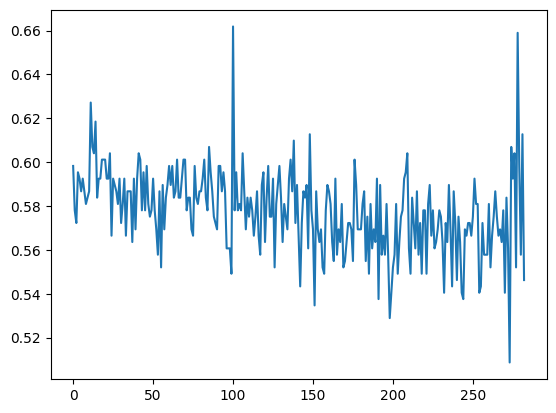

In [25]:
display_sigma_tendancy(sub_solar_0, 0.0005)

It seems that the longer wavelengths show more diverse errors overall.
We could consider applying different offsets depending on the wavelength range.
Although this could lead to slight improvements, it likely won't reduce the overall error scale significantly.

In [29]:
def solar_intensity_and_std(solar_system, start_planet=0, end_planet=100, threshold=0.00010, exclude=True):
    if solar_system == 1: labels = solar_1_labels
    else: labels = solar_0_labels
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    if exclude == True:
        for i in range(start_planet, end_planet):
            if pd.DataFrame(labels[:,1:]).std(axis=1)[i] > threshold:
                continue
            axes[0].plot(labels[i][1:], label=f"Original {i} (pre_train)", alpha=0.7)
            axes[0].set_xlabel("wl")
            axes[0].set_ylabel("intensity")
            axes[0].set_title(f'intensity of wavelengths in solar {solar_system}')
        axes[1].plot(pd.DataFrame(labels[:,1:]).std(axis=1))
        axes[1].set_title(f'solar {solar_system} intensity std')
        axes[1].set_xlabel("planets")
        axes[1].set_ylabel("std")
        plt.show()
    else:
        for i in range(start_planet, end_planet):
            axes[0].plot(labels[i][1:], label=f"Original {i} (pre_train)", alpha=0.7)
            axes[0].set_xlabel("wl")
            axes[0].set_ylabel("intensity")
            axes[0].set_title(f'intensity of wavelengths in solar {solar_system}')
        axes[1].plot(pd.DataFrame(labels[:,1:]).std(axis=1))
        axes[1].set_title(f'solar {solar_system} intensity std')
        axes[1].set_xlabel("planets")
        axes[1].set_ylabel("std")
        plt.show()
        
    

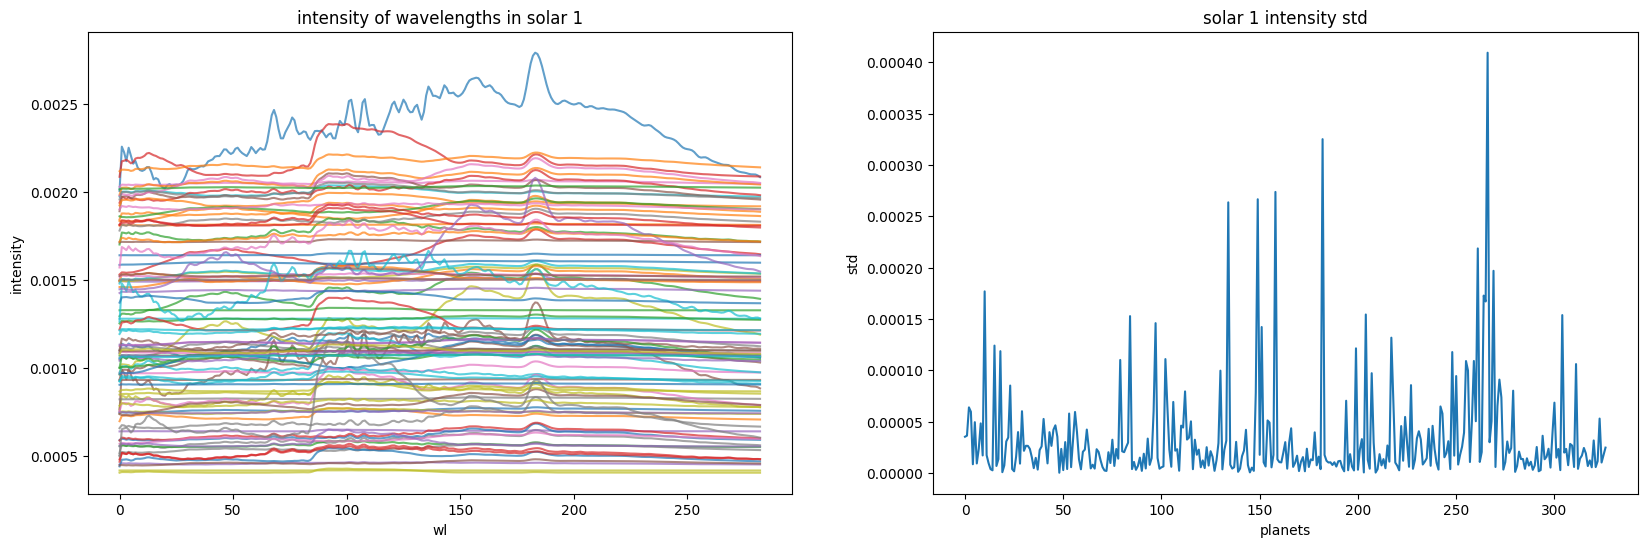

In [30]:
solar_intensity_and_std(1, 0, 100, 0.00010, False)

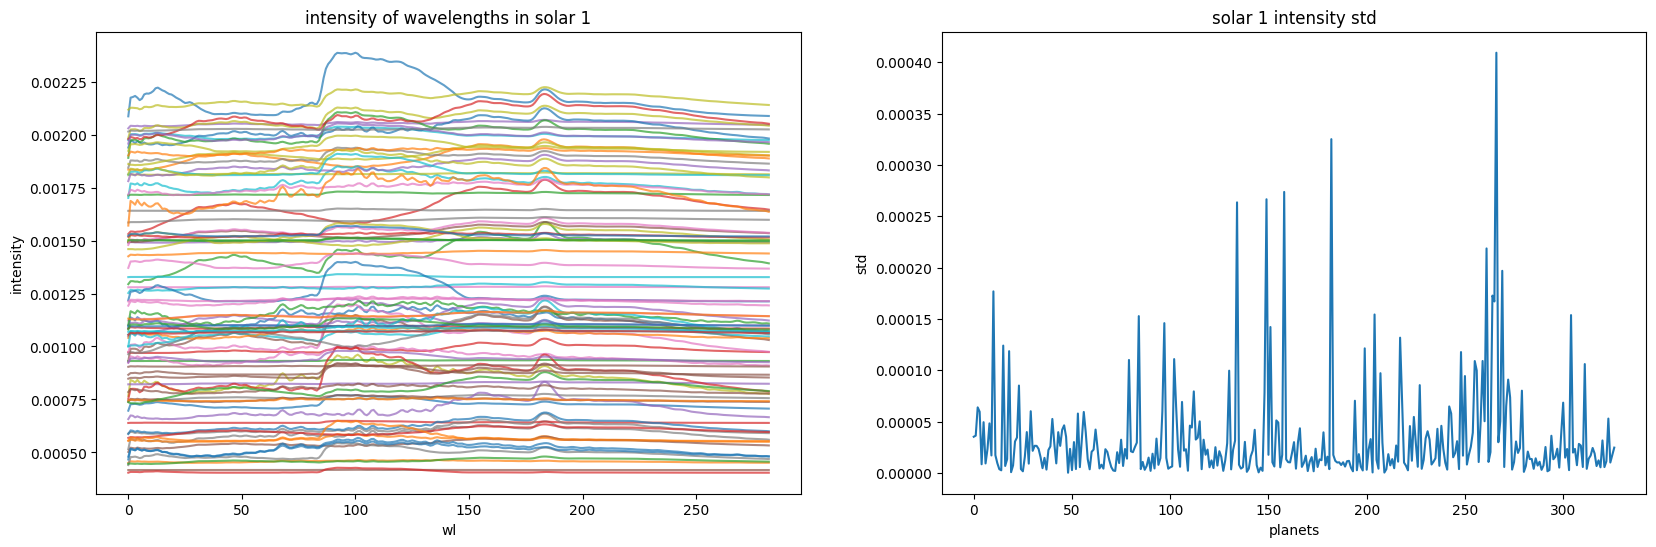

In [31]:
solar_intensity_and_std(1, 0, 100, 0.00010, True)

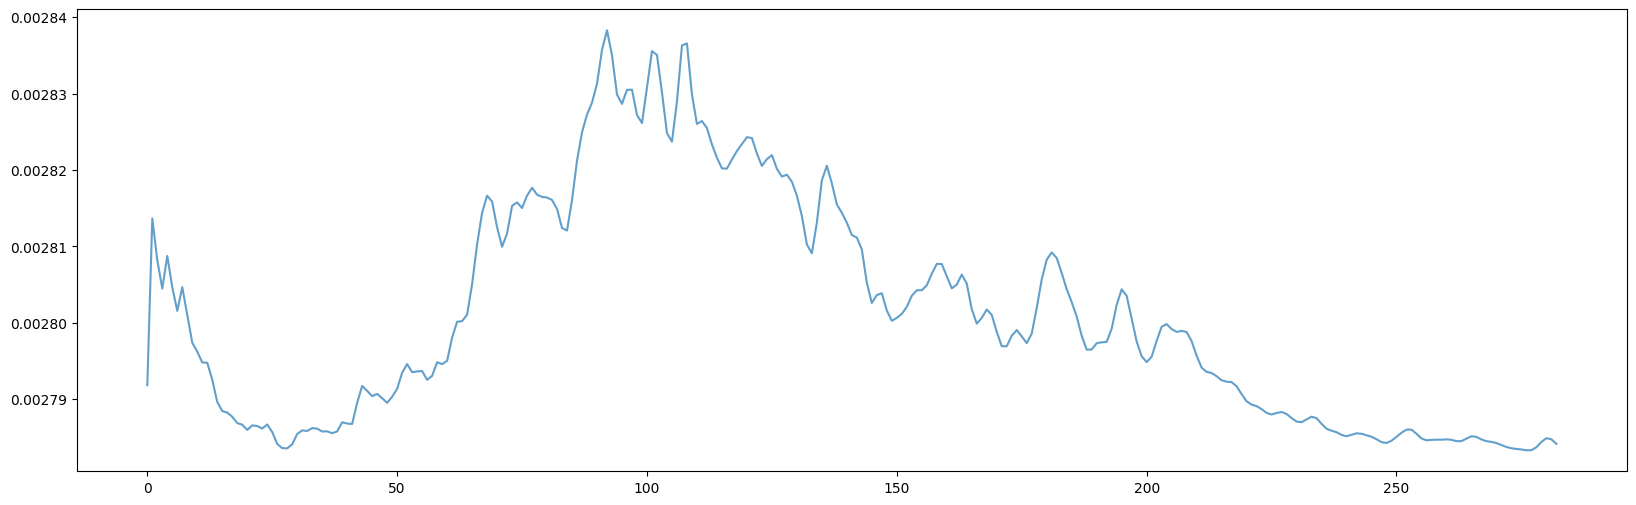

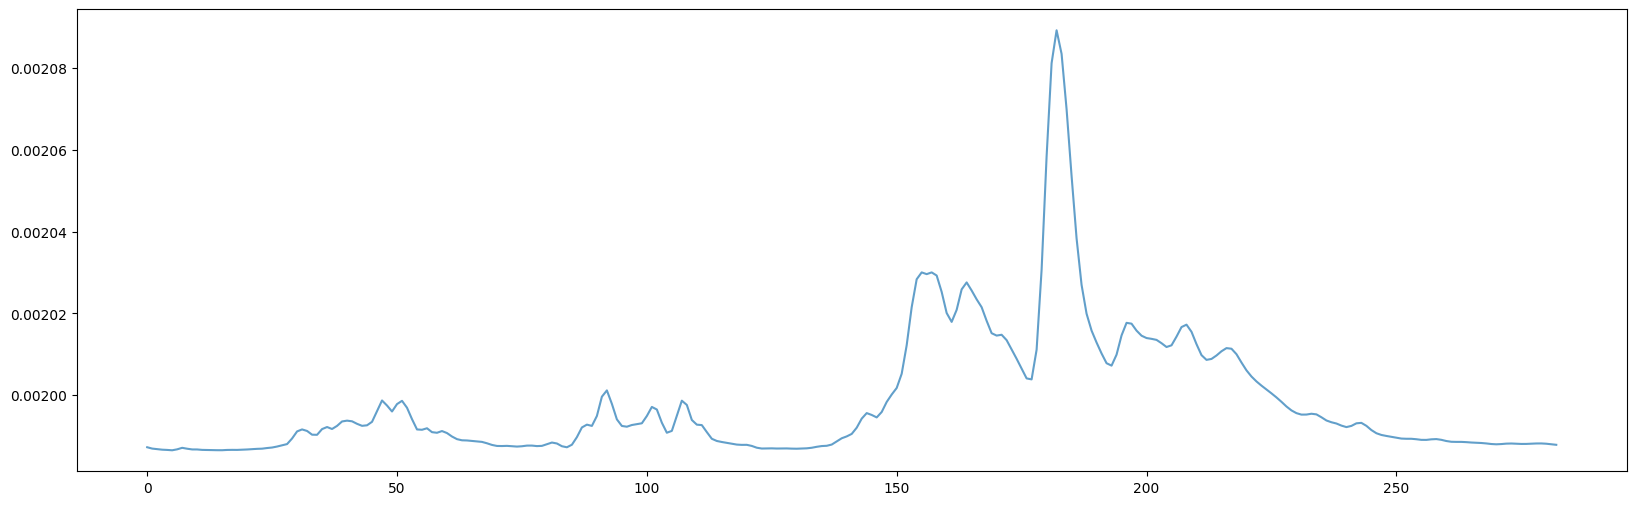

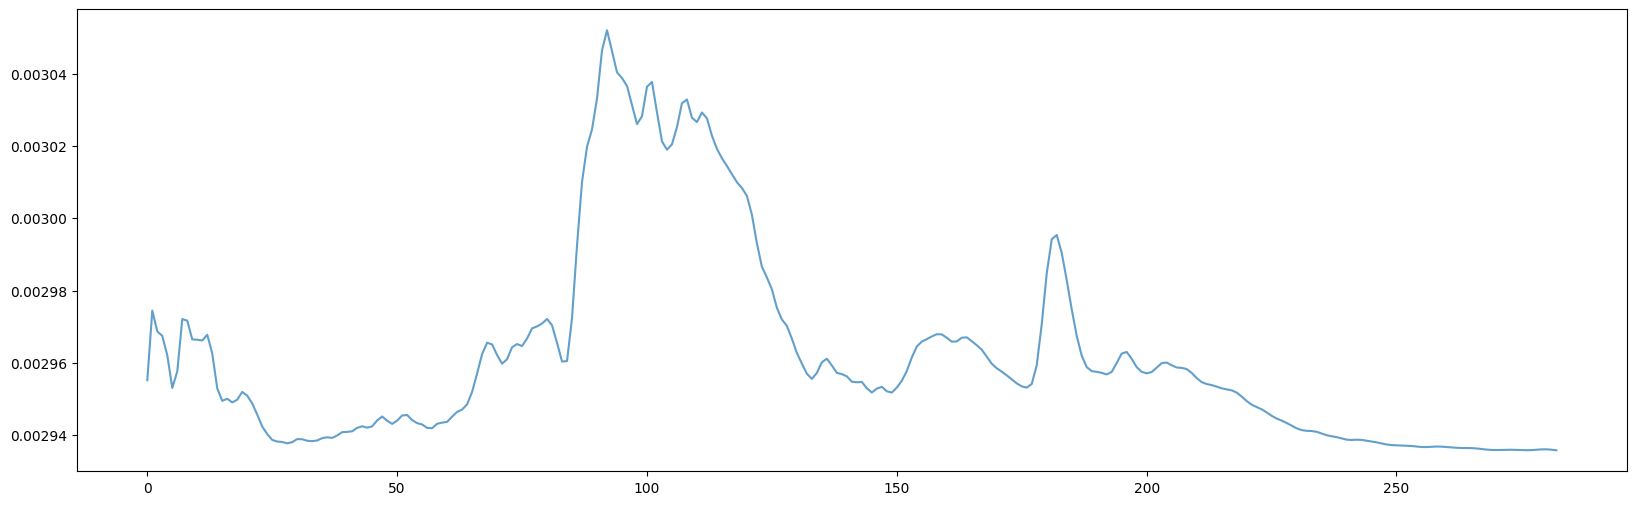

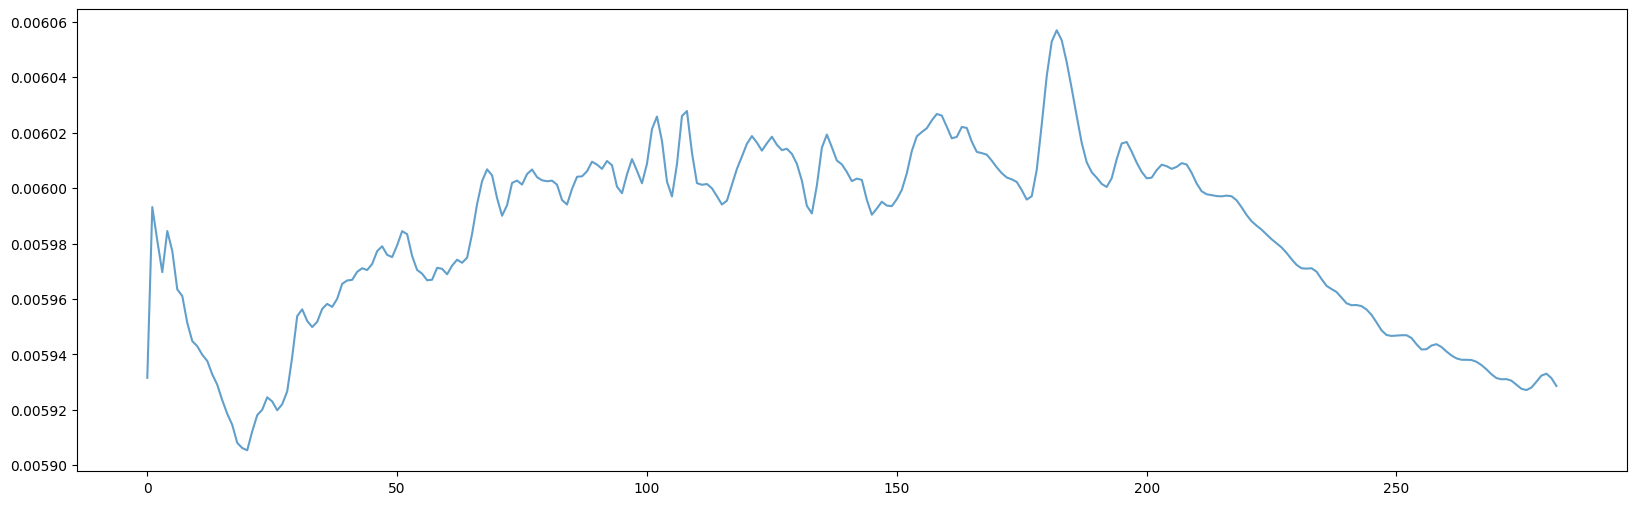

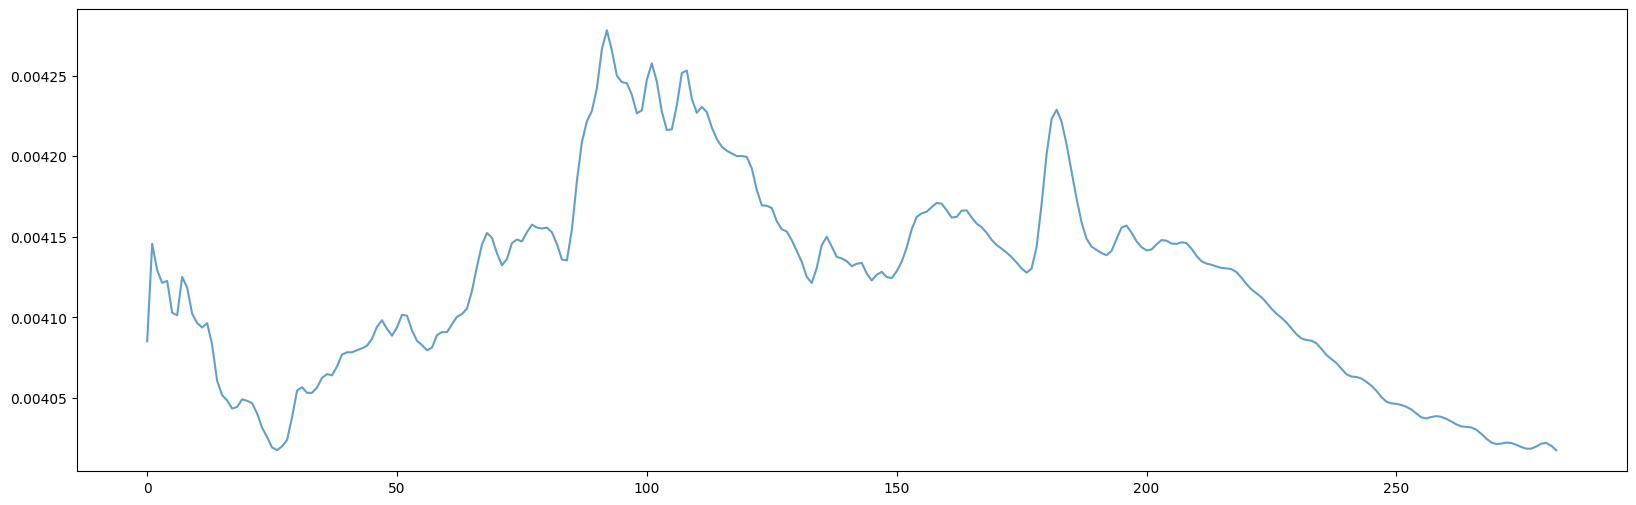

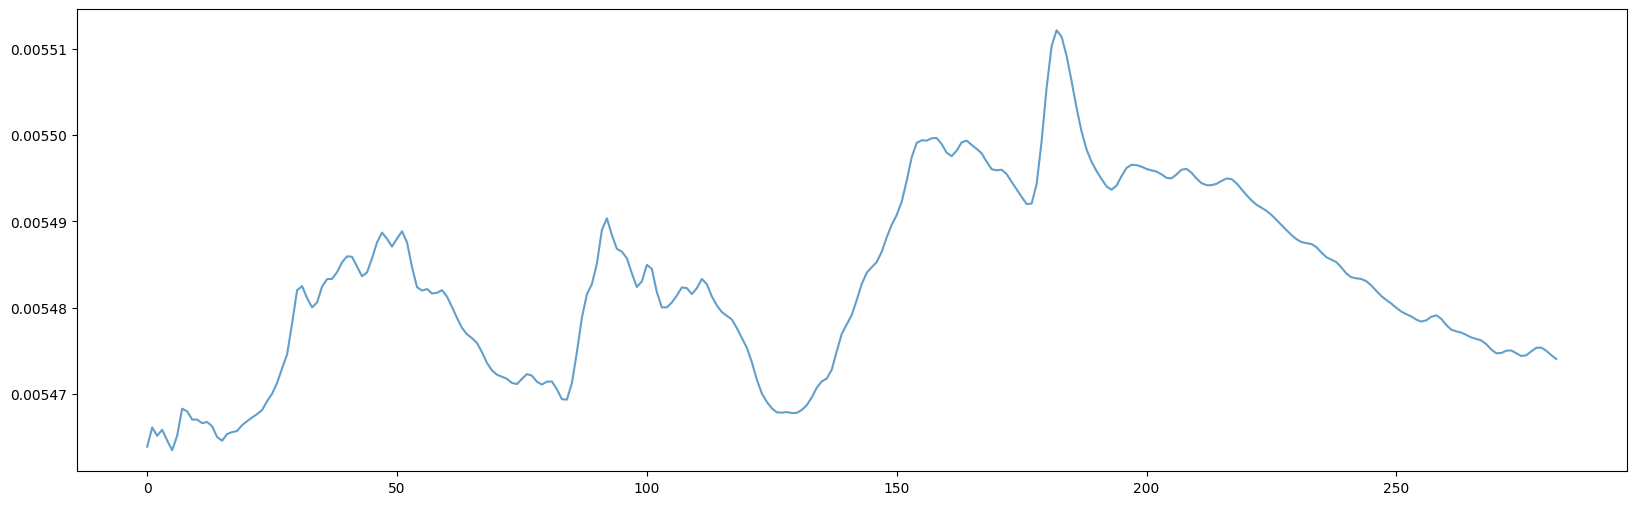

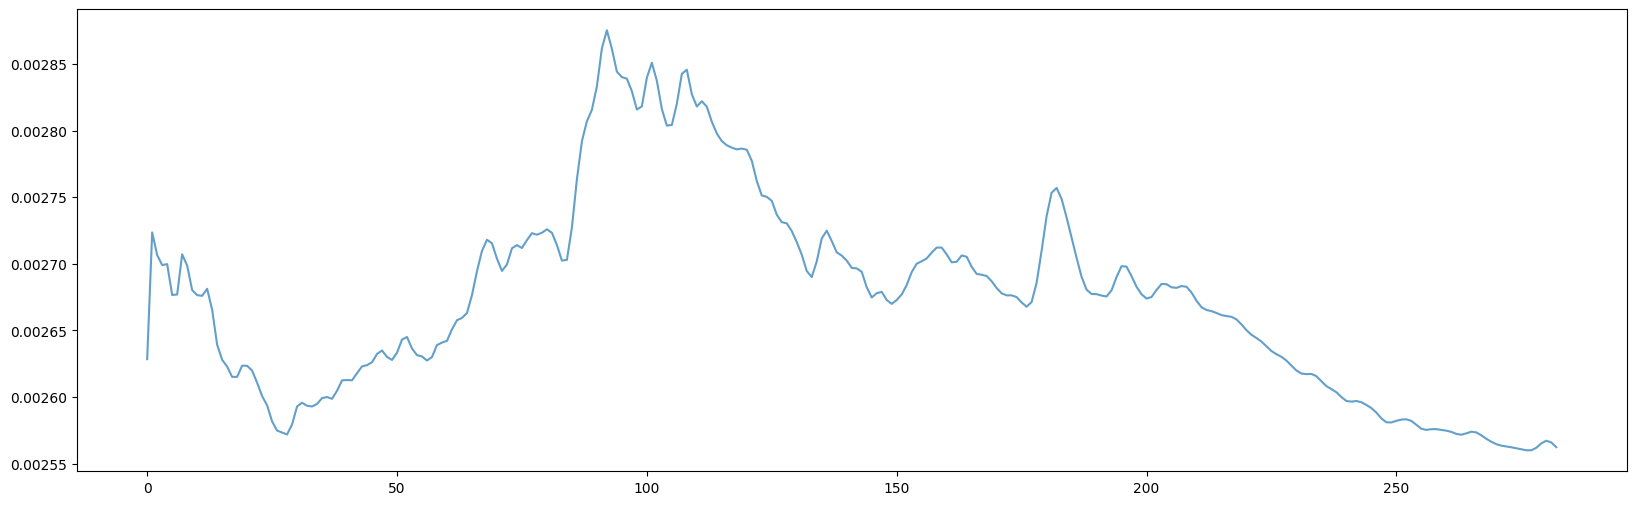

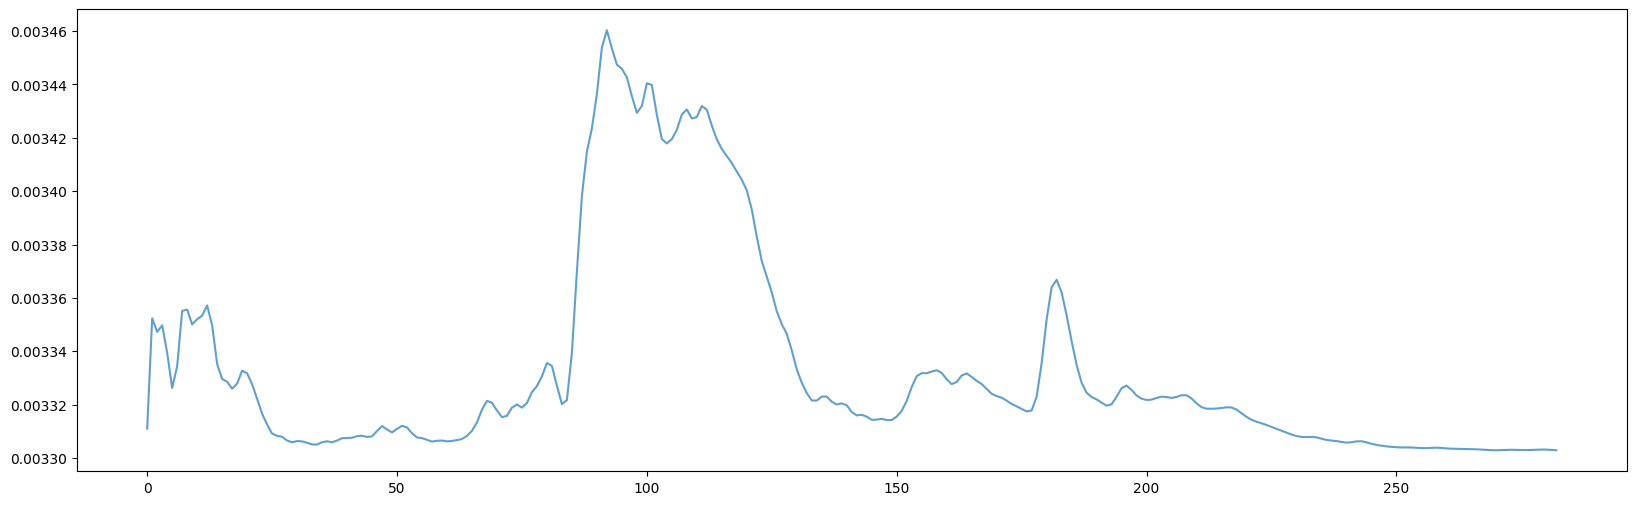

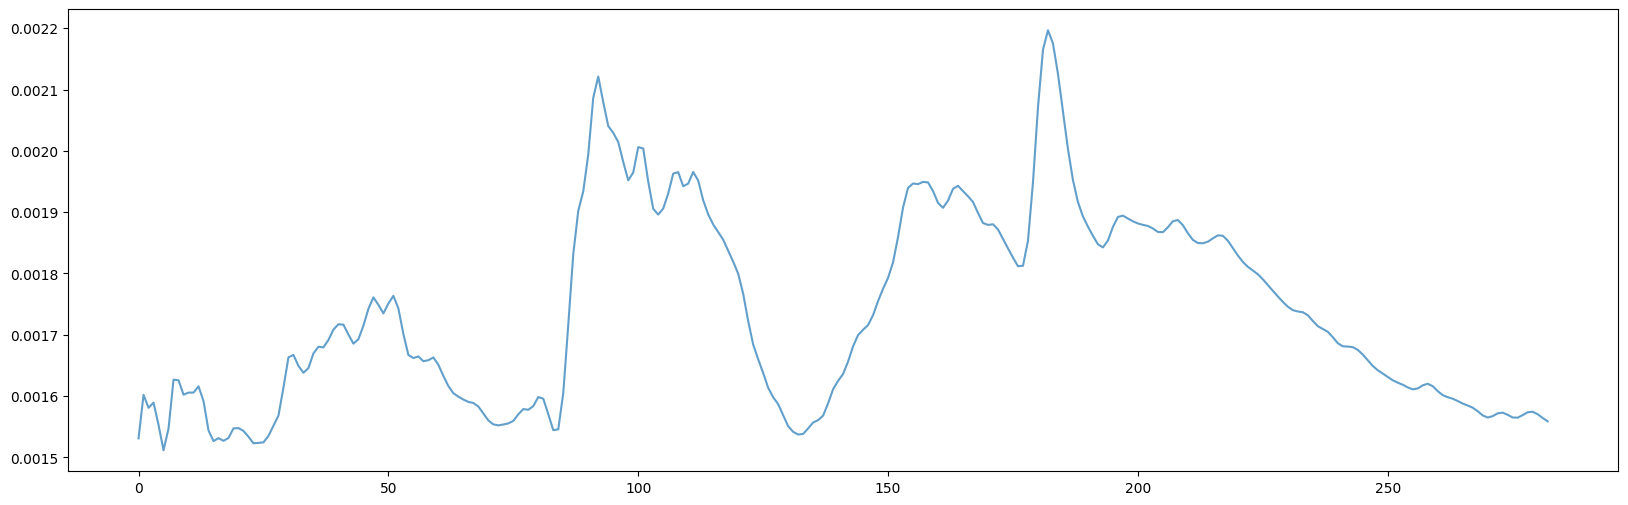

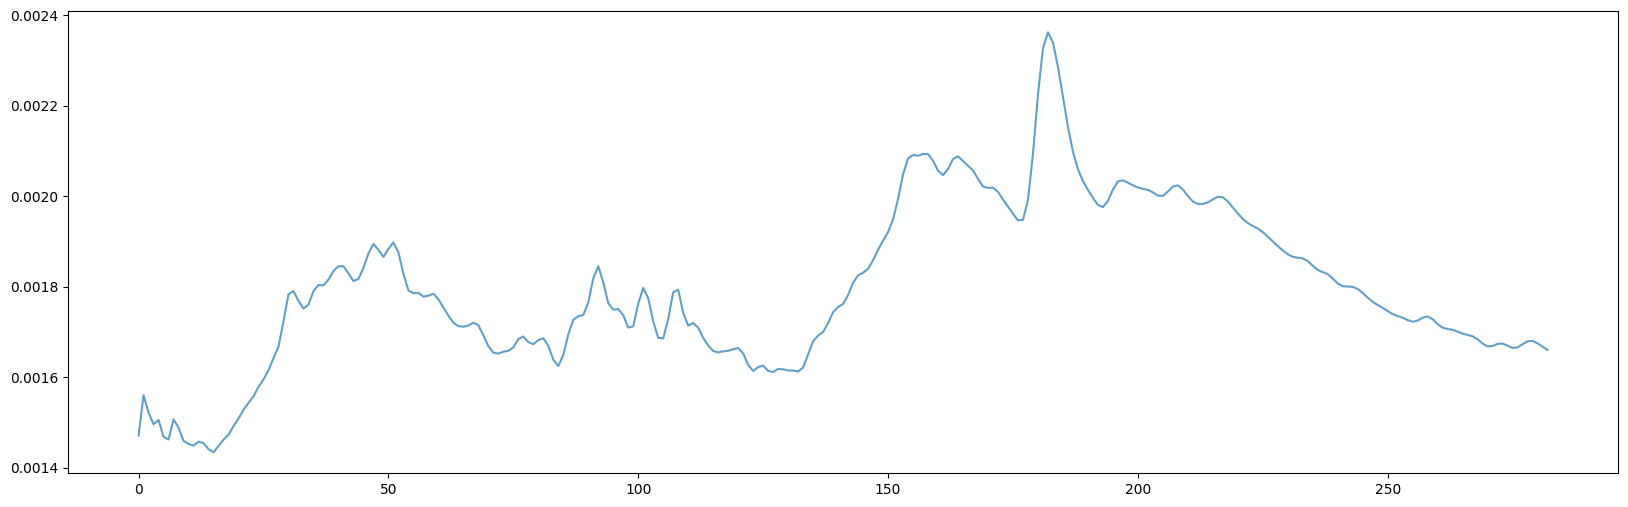

In [32]:
for i in range(10):
    plt.figure(figsize=(20,6))
    plt.plot(solar_0_labels[i][1:], label=f"Original {0} (pre_train)", alpha=0.7)
    plt.show()
        

In [33]:
for i, v in enumerate(solar_0_labels[1][1:]):
    if v > 0.00204:
        print(i)

180
181
182
183
184
185


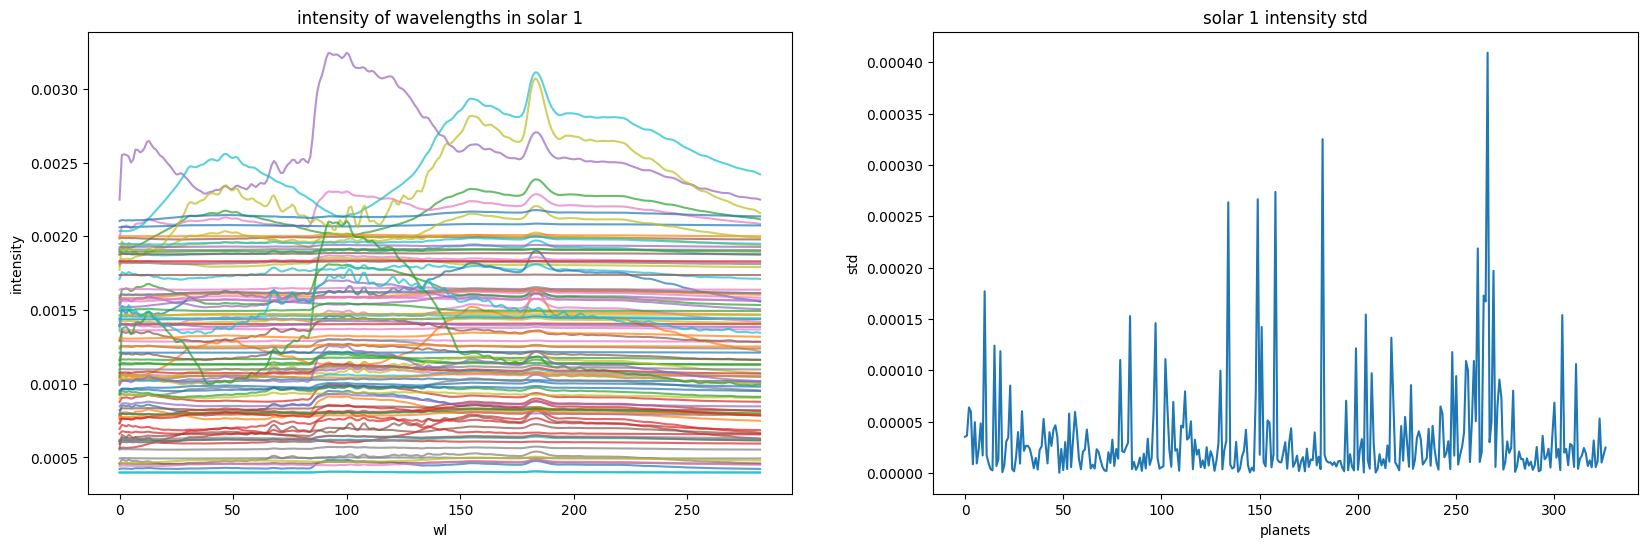

In [34]:
solar_intensity_and_std(1, 100, 200, 0.00010, False)

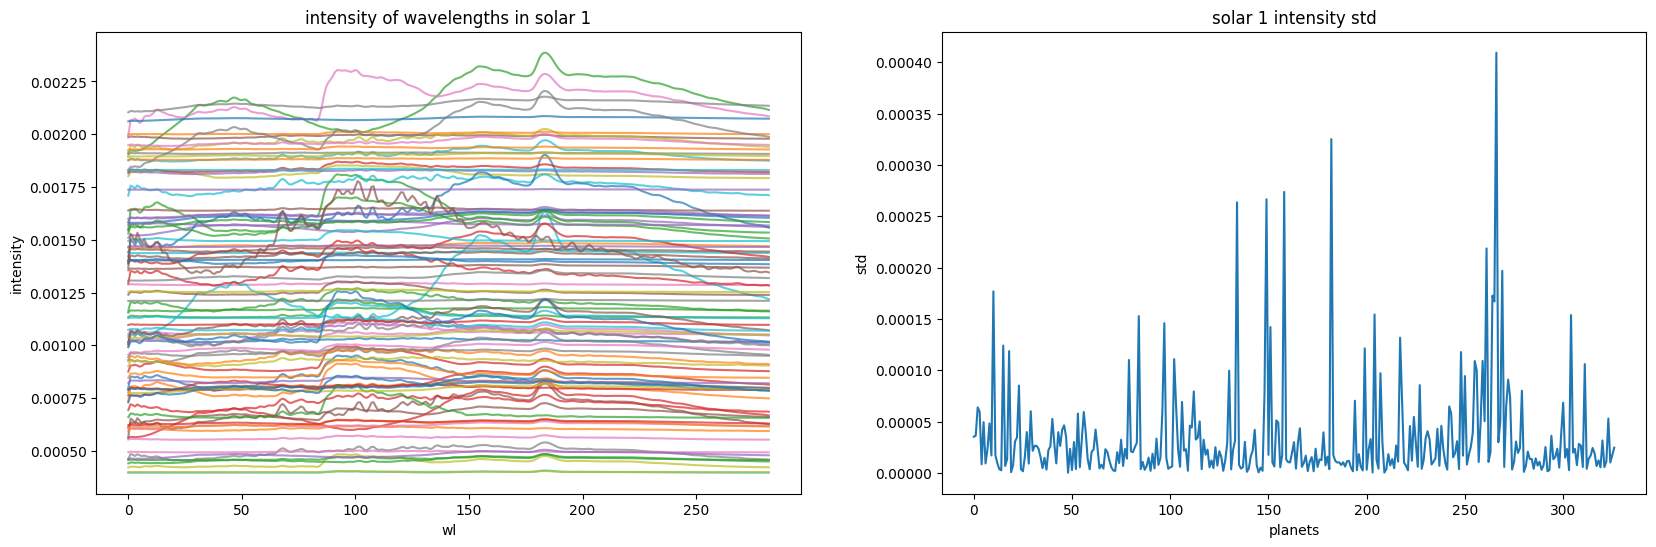

In [35]:
solar_intensity_and_std(1, 100, 200, 0.00015, True)

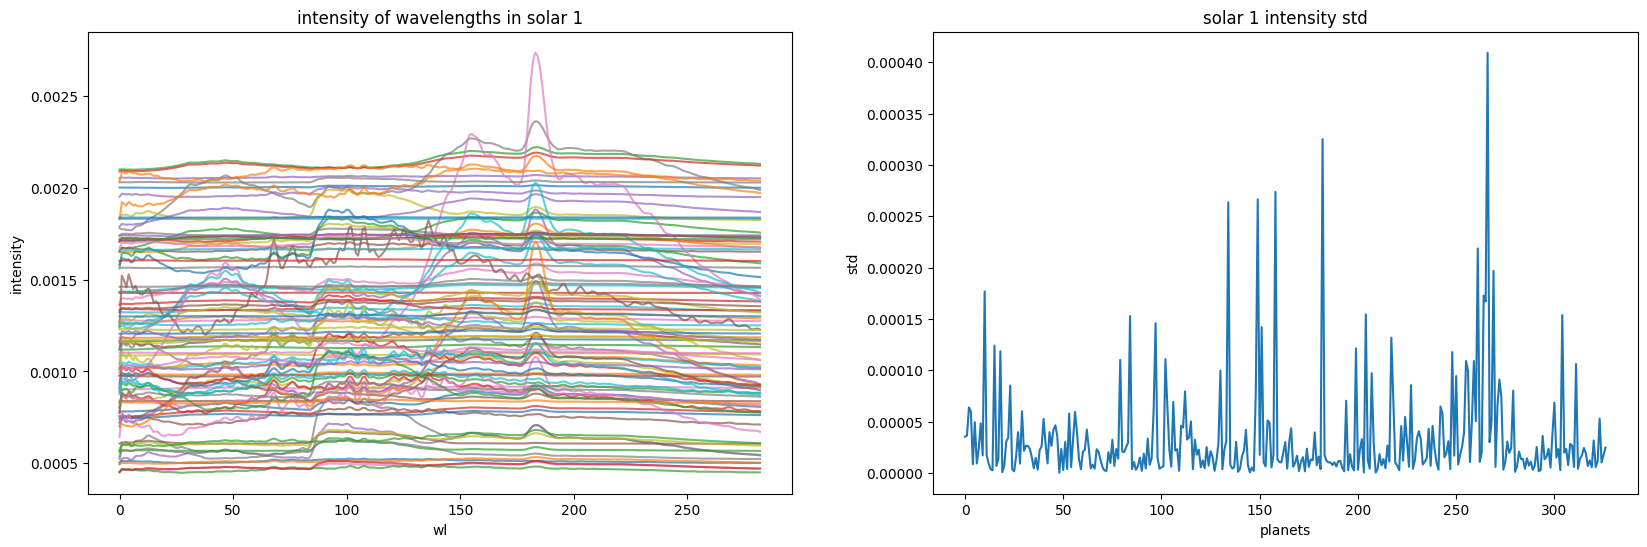

In [36]:
solar_intensity_and_std(1, 200, 300, 0.00010, False)

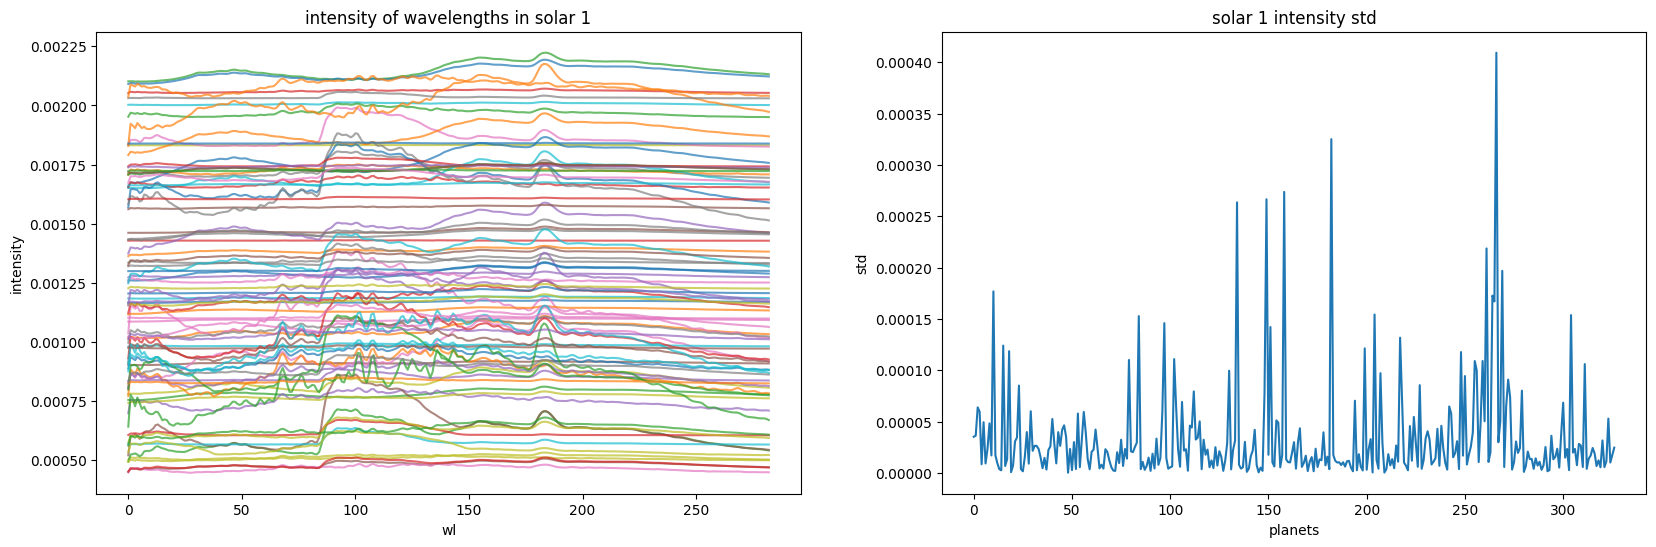

In [37]:
solar_intensity_and_std(1, 200, 300, 0.00010, True)

In [38]:
cnt = 0 
for i in range(len(pd.DataFrame(solar_1_labels[:,1:]).std(axis=1))):
    if pd.DataFrame(solar_1_labels[:,1:]).std(axis=1)[i] > 0.00010:
        cnt += 1
print(cnt)

25


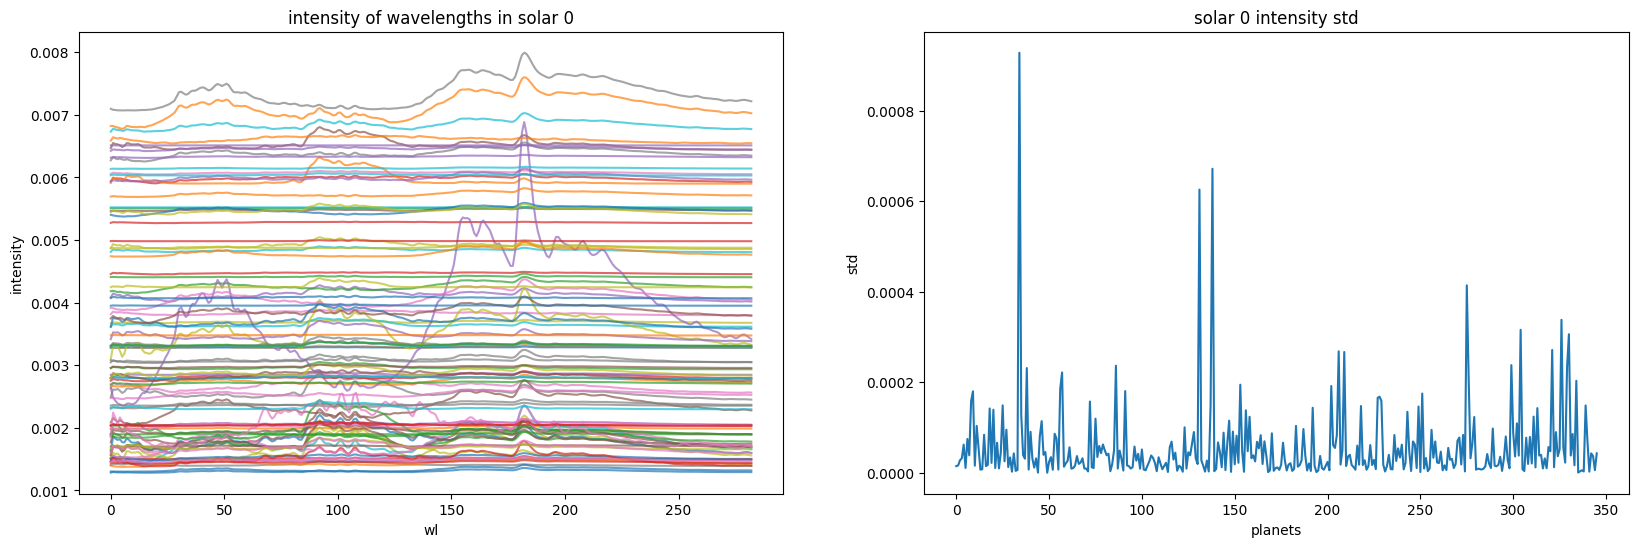

In [39]:
solar_intensity_and_std(0, 0, 100, 0.00010, False)

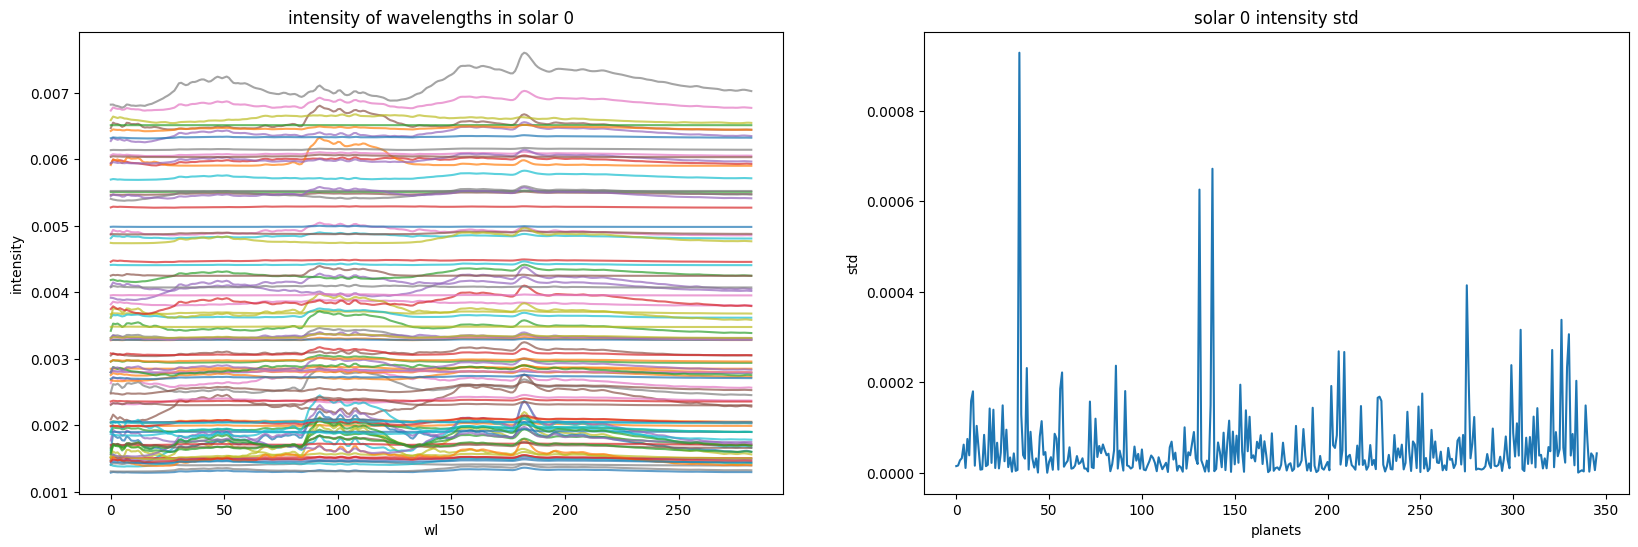

In [40]:
solar_intensity_and_std(0, 0, 100, 0.00020, True)

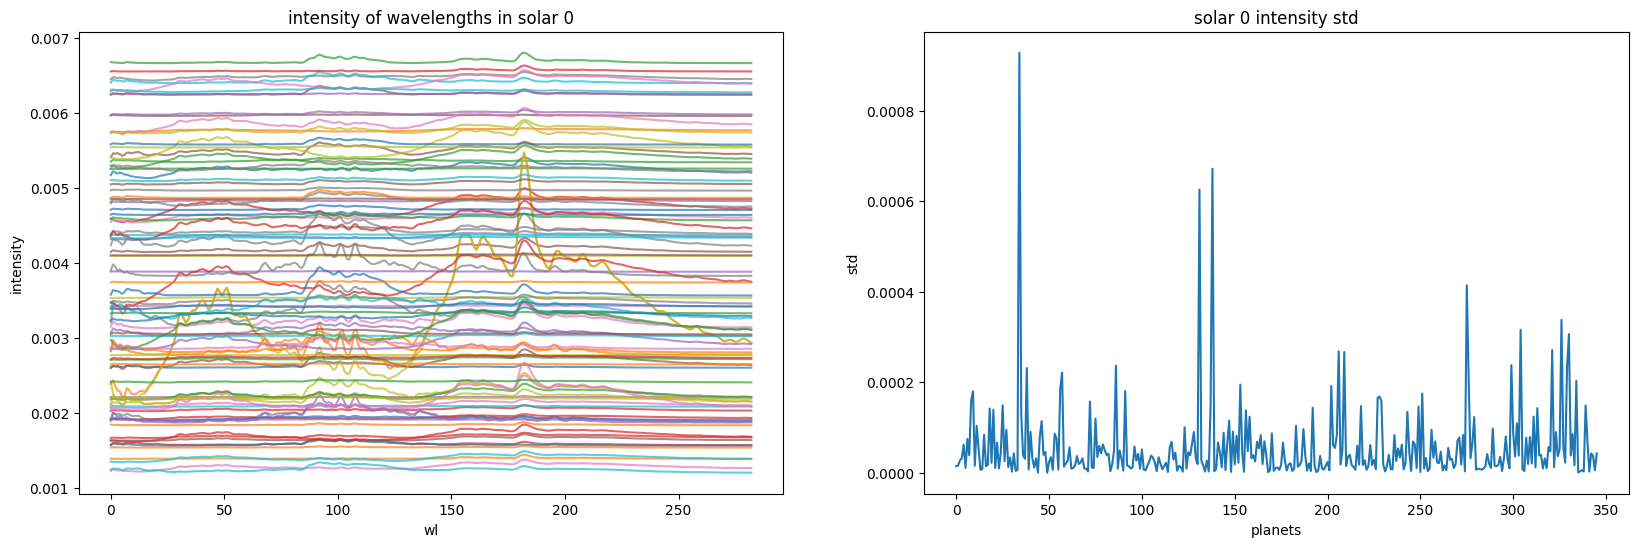

In [41]:
solar_intensity_and_std(0, 100, 200, 0.00010, False)

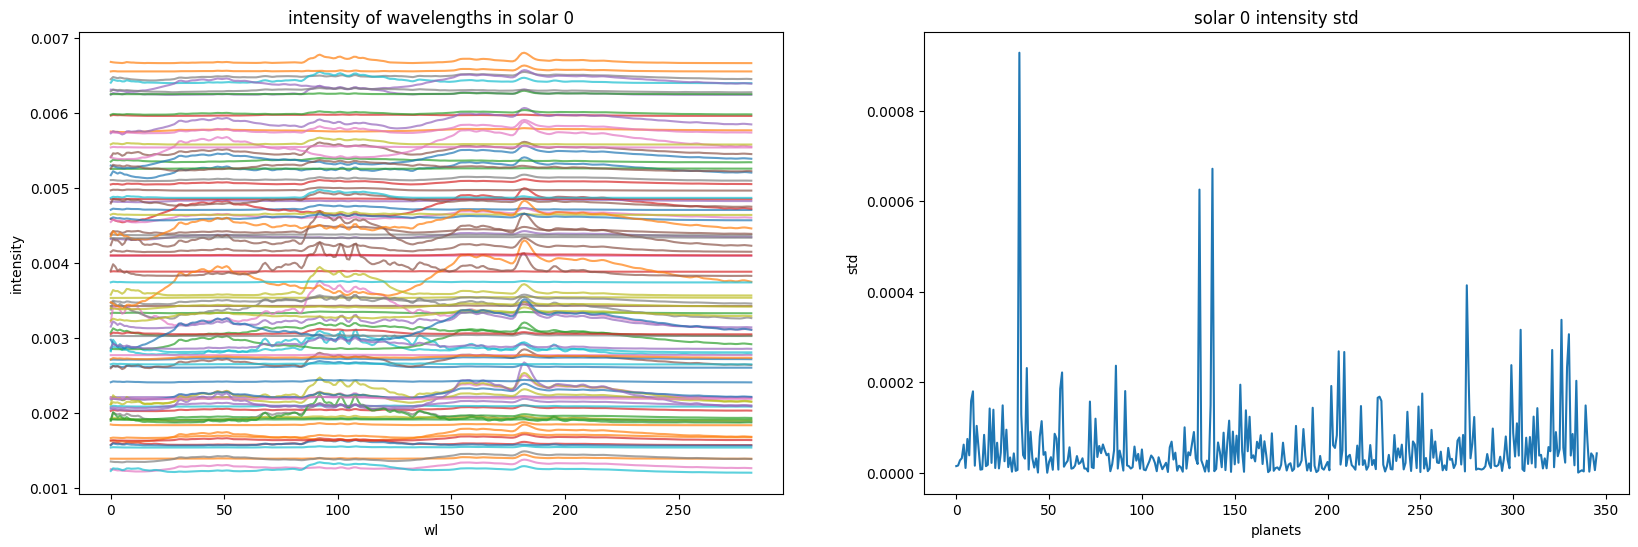

In [42]:
solar_intensity_and_std(0, 100, 200, 0.00025, True)

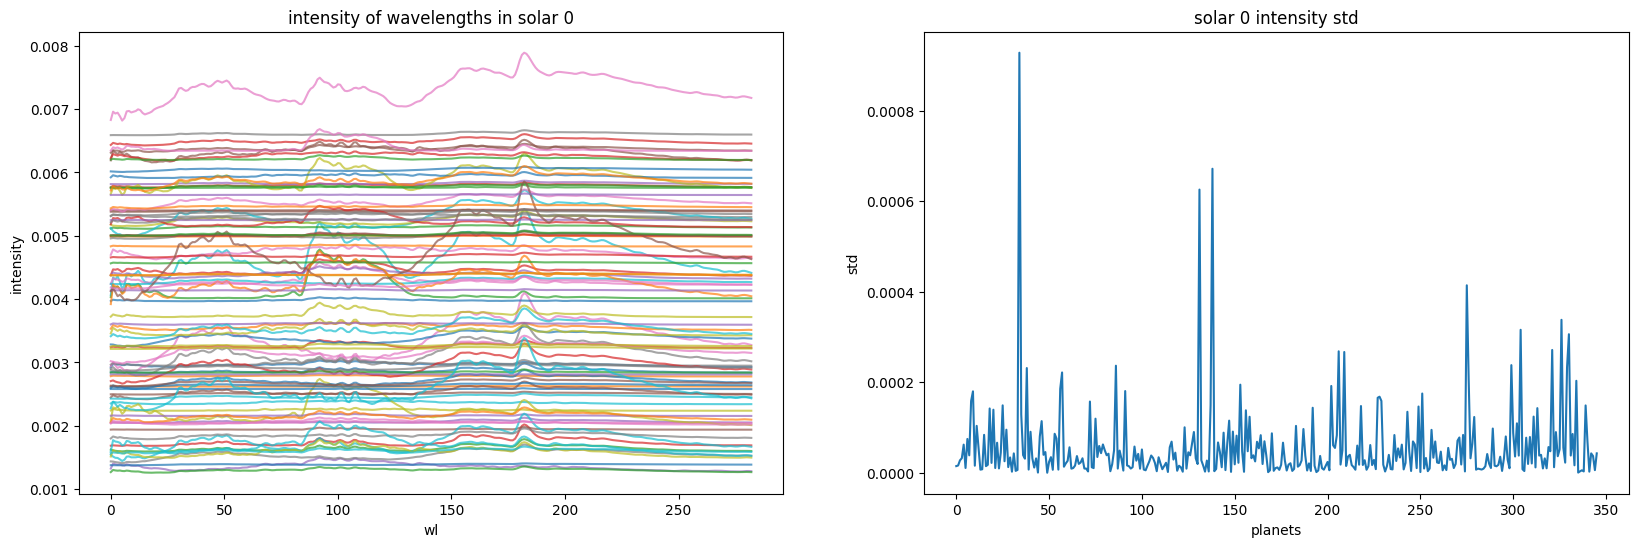

In [43]:
solar_intensity_and_std(0, 200, 300, 0.00020, False)

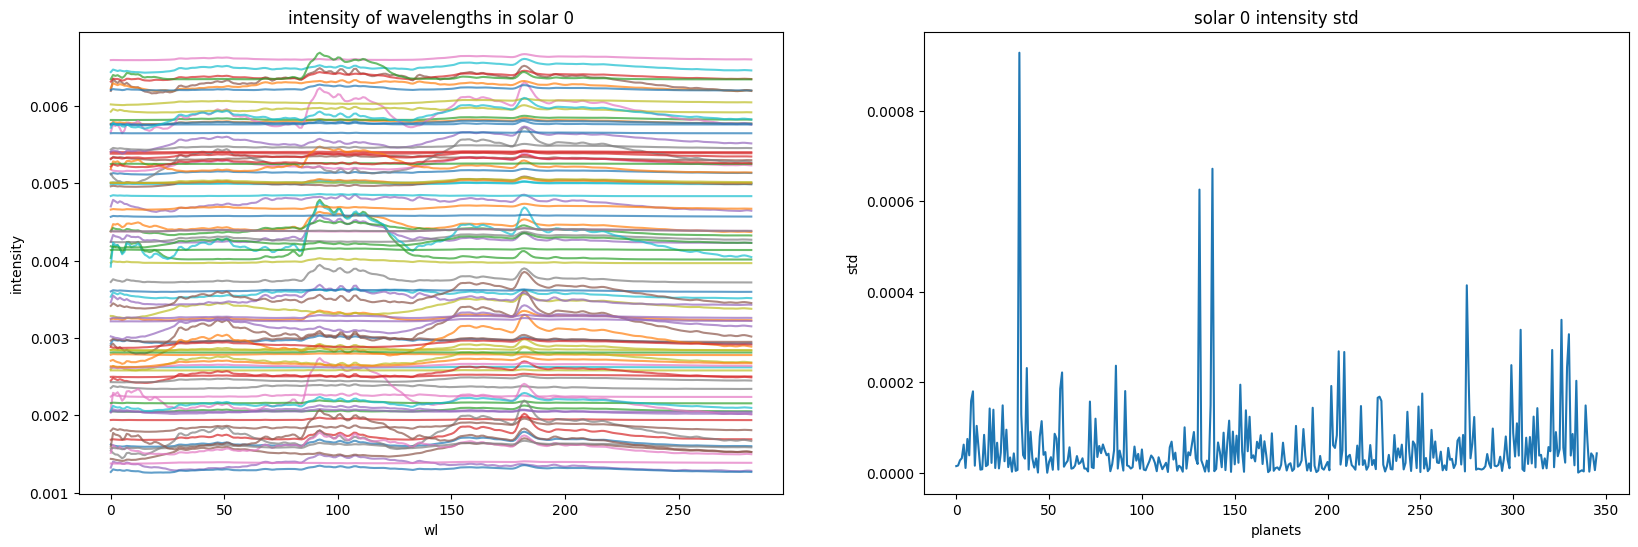

In [44]:
solar_intensity_and_std(0, 200, 300, 0.00020, True)

In [45]:
cnt = 0 
for i in range(len(pd.DataFrame(solar_0_labels[:,1:]).std(axis=1))):
    if pd.DataFrame(solar_0_labels[:,1:]).std(axis=1)[i] > 0.00020:
        cnt += 1
print(cnt)

17


On average, the standard deviation across wavelengths is around 0.0015.       
This means that if the mean is accurately estimated, the overall error remains very small.-> high accuracy, low uncertainty.         
So the key challenge lies in how precisely we can predict the mean.

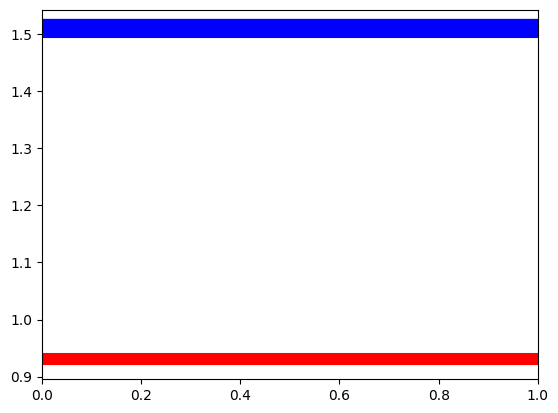

In [46]:
for i in range(len(train_adc_info)):
    if list(train_adc_info['star'])[i] == 1:
        plt.axhline(list(train_adc_info['AIRS-CH0_adc_gain'])[i],c='r')
    else:
        plt.axhline(list(train_adc_info['AIRS-CH0_adc_gain'])[i],c='b')
plt.show()

In [47]:
solar_1_gain, solar_2_gain = pd.DataFrame(np.array(train_adc_info['AIRS-CH0_adc_gain'])[indexes]).describe(), pd.DataFrame(np.array(train_adc_info['AIRS-CH0_adc_gain'])[exdexes]).describe()
solar_1_gain, solar_2_gain

(                0
 count  327.000000
 mean     0.930868
 std      0.002896
 min      0.922824
 25%      0.929184
 50%      0.931187
 75%      0.932911
 max      0.939917,
                 0
 count  346.000000
 mean     1.512498
 std      0.005549
 min      1.495685
 25%      1.508697
 50%      1.512866
 75%      1.516304
 max      1.525757)

We can judge solar system depends on AIRS-CH0_adc_gain     
solar 1: 0.930868 ~ 0.939917     
solar 0: 1.495685 ~ 1.525757

75% ~0.0003 0.598 solar 0: 0.000243 0.621 solar 1: 0.000282
50% ~0.00015 0.580 solar 0: 0.000114 0.594 solar 1: 0.000124

New solar system -> New ratio

Estimate planet's mean intensity

In [57]:
train = pre_train.copy()
train_solar1 = train[indexes]
train_solar0 = train[exdexes]

In [58]:
solar_1_estimated_mean=[]
solar_0_estimated_mean=[]
for i in range(len(train_adc_info)):
    estimated_points = np.zeros(283,)
    for j in range(283):
        mean_entire = (np.mean(out_of_transit[i][0][:,j]) +
            np.mean(out_of_transit[i][1][:,j]) +
            np.mean(in_transit[i][:,j])) / 3
        estimated_points[j] = mean_entire
    if i in indexes: # solar 1
        solar_1_estimated_mean.append(np.mean(estimated_points/1000))
        
    else: # solar 2
        solar_0_estimated_mean.append(np.mean(estimated_points/1000))

In [59]:
solar_1_label_mean = np.zeros((len(indexes),))
solar_0_label_mean = np.zeros((len(exdexes),))
for i in range(len(indexes)):
    solar_1_label_mean[i] = np.mean(solar_1_labels[i][1:])
for i in range(len(exdexes)):
    solar_0_label_mean[i] = np.mean(solar_0_labels[i][1:])


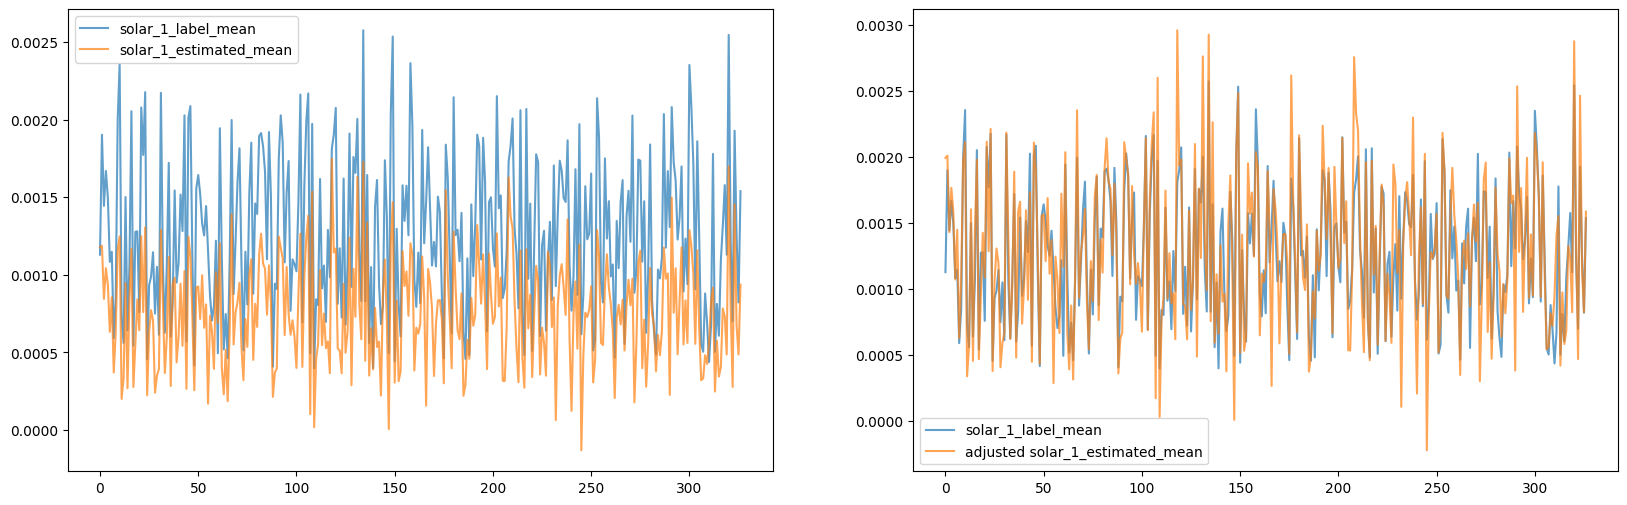

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
axes[0].plot(solar_1_label_mean, '-', label='solar_1_label_mean', alpha=0.7)
axes[0].plot(solar_1_estimated_mean,'-', label='solar_1_estimated_mean', alpha=0.7)
axes[0].legend(loc='best')
axes[1].plot(np.array(solar_1_label_mean), '-', label='solar_1_label_mean', alpha=0.7)
axes[1].plot(np.array(solar_1_estimated_mean)/0.59,'-', label='adjusted solar_1_estimated_mean', alpha=0.7)
axes[1].legend(loc='best')
plt.show()

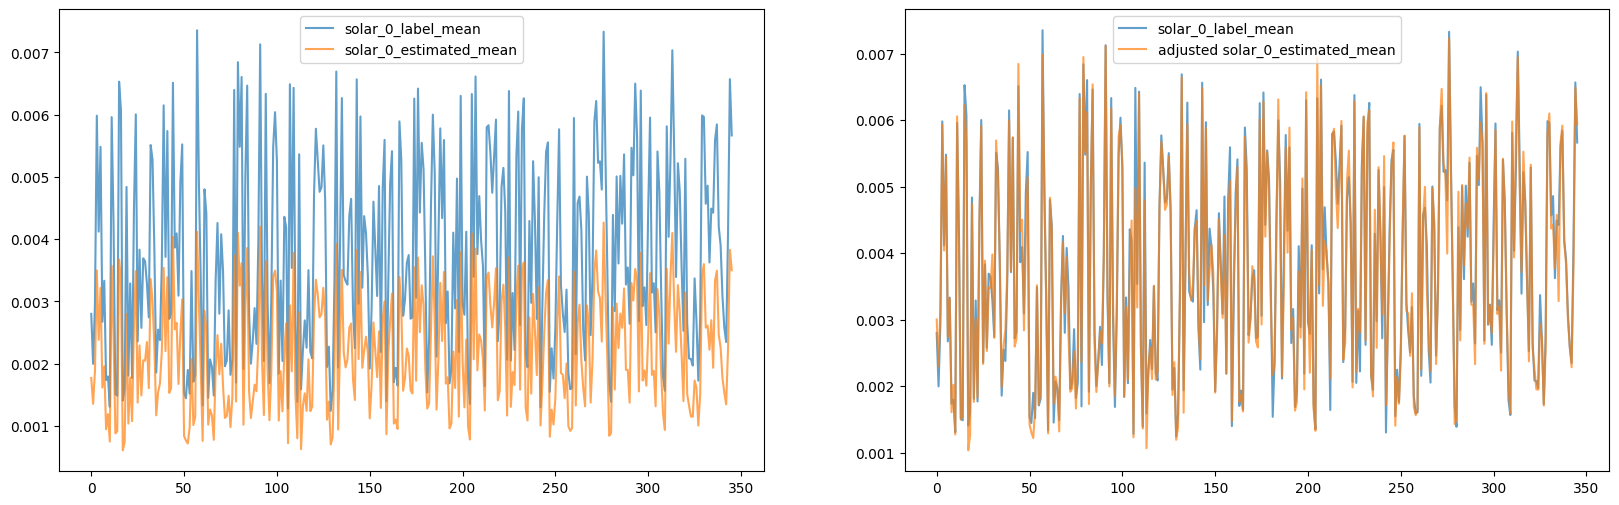

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
axes[0].plot(solar_0_label_mean, '-', label='solar_0_label_mean', alpha=0.7)
axes[0].plot(solar_0_estimated_mean,'-', label='solar_0_estimated_mean', alpha=0.7)
axes[0].legend(loc='best')
axes[1].plot(np.array(solar_0_label_mean), '-', label='solar_0_label_mean', alpha=0.7)
axes[1].plot(np.array(solar_0_estimated_mean)/0.59,'-', label='adjusted solar_0_estimated_mean', alpha=0.7)
axes[1].legend(loc='best')
plt.show()

In [62]:
solar_0_precision, solar_1_precision =  pd.DataFrame(np.abs(np.array(solar_0_estimated_mean)/0.6-solar_0_label_mean)).describe(), pd.DataFrame(np.abs(np.array(solar_1_estimated_mean)/0.65-solar_1_label_mean)).describe()
solar_0_precision, solar_1_precision

(                0
 count  346.000000
 mean     0.000199
 std      0.000191
 min      0.000001
 25%      0.000072
 50%      0.000152
 75%      0.000249
 max      0.001589,
                   0
 count  3.270000e+02
 mean   2.141994e-04
 std    1.890770e-04
 min    2.098532e-07
 25%    7.476780e-05
 50%    1.654341e-04
 75%    2.905220e-04
 max    1.227838e-03)

In [63]:
def precision(solar_system, ratio, percentile):
    if solar_system == 0:
        precision = pd.DataFrame(np.abs(np.array(solar_0_estimated_mean)/ratio-solar_0_label_mean)).describe().loc[f'{percentile}%'][0]
    else: 
        precision = pd.DataFrame(np.abs(np.array(solar_1_estimated_mean)/ratio-solar_1_label_mean)).describe().loc[f'{percentile}%'][0]
    return precision

In [64]:
for i in range(-100, 100, 1):
    print(f'Ratio {0.60+i*0.001} solar 0: {precision(0, 0.60+i*0.001, 75)} Ratio {0.62+i*0.001} solar 1: {precision(1, 0.62+i*0.001, 75)}')

Ratio 0.5 solar 0: 0.0009216138578011042 Ratio 0.52 solar 1: 0.00037806776633273425
Ratio 0.501 solar 0: 0.0009106911343007771 Ratio 0.521 solar 1: 0.0003754450863307628
Ratio 0.502 solar 0: 0.0008997702124113917 Ratio 0.522 solar 1: 0.0003714554561001928
Ratio 0.503 solar 0: 0.0008876455647859392 Ratio 0.523 solar 1: 0.00036853205954113654
Ratio 0.504 solar 0: 0.000874645560324727 Ratio 0.524 solar 1: 0.00036443700367955623
Ratio 0.505 solar 0: 0.0008609239432208783 Ratio 0.525 solar 1: 0.0003614800370753562
Ratio 0.506 solar 0: 0.0008472565617577573 Ratio 0.526 solar 1: 0.00035931295906119394
Ratio 0.507 solar 0: 0.0008338824132188526 Ratio 0.527 solar 1: 0.0003559483320672637
Ratio 0.508 solar 0: 0.0008243394004380678 Ratio 0.528 solar 1: 0.0003546850280478895
Ratio 0.509 solar 0: 0.0008156119631359666 Ratio 0.529 solar 1: 0.0003505562999614074
Ratio 0.51 solar 0: 0.0008075094251592404 Ratio 0.53 solar 1: 0.00034837635978977356
Ratio 0.511 solar 0: 0.000798086666519367 Ratio 0.531 s

0.5~0.7:0.0009
0.52~0.72:0.0003

In [65]:
for i in range(-30, 10, 1):
    print(f'Ratio {0.60+i*0.001} solar 0: {precision(0, 0.60+i*0.001, 50)} Ratio {0.62+i*0.001} solar 1: {precision(1, 0.62+i*0.001, 50)}')

Ratio 0.57 solar 0: 0.00015328861905561679 Ratio 0.59 solar 1: 0.00012791889421731123
Ratio 0.571 solar 0: 0.00014789333856956742 Ratio 0.591 solar 1: 0.00012668810983263086
Ratio 0.572 solar 0: 0.00014054824998842308 Ratio 0.592 solar 1: 0.00012521078764968002
Ratio 0.573 solar 0: 0.0001400550007182792 Ratio 0.593 solar 1: 0.00012535521177681913
Ratio 0.574 solar 0: 0.00013617084501074531 Ratio 0.594 solar 1: 0.00012493591775520826
Ratio 0.575 solar 0: 0.0001364164858423622 Ratio 0.595 solar 1: 0.0001255245412669215
Ratio 0.576 solar 0: 0.00013156631229786558 Ratio 0.596 solar 1: 0.00012512990595856216
Ratio 0.577 solar 0: 0.00012499558625380172 Ratio 0.597 solar 1: 0.00012345203738629114
Ratio 0.578 solar 0: 0.00012256292378739933 Ratio 0.598 solar 1: 0.00012503232027739398
Ratio 0.579 solar 0: 0.0001169172383601565 Ratio 0.599 solar 1: 0.0001272285248463971
Ratio 0.58 solar 0: 0.00011446327540100363 Ratio 0.6 solar 1: 0.0001269561670848619
Ratio 0.581 solar 0: 0.00011554886680515265

75% ~0.0003  0.598 solar 0: 0.000243 0.621 solar 1: 0.000282    
50% ~0.00015 0.580 solar 0: 0.000114 0.594 solar 1: 0.000124   

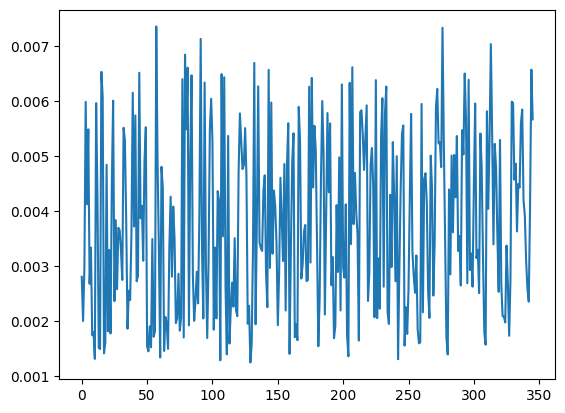

In [66]:
plt.plot(solar_0_labels[:, 1:].mean(axis=1))

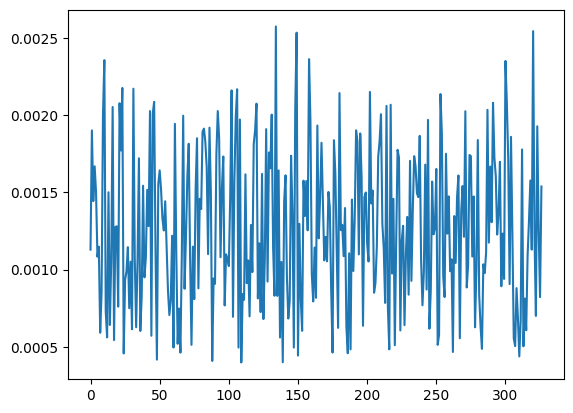

In [67]:
plt.plot(solar_1_labels[:, 1:].mean(axis=1))

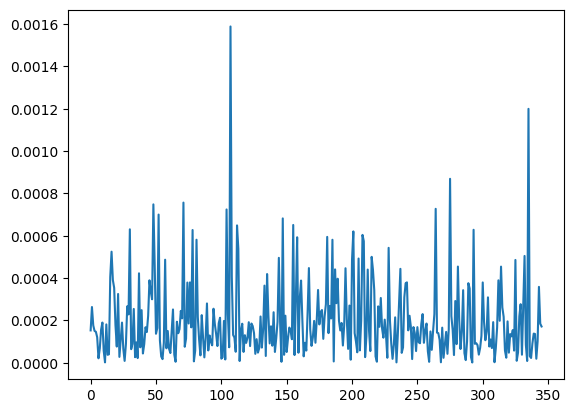

In [68]:
plt.plot(np.abs(np.array(solar_0_estimated_mean)/0.6-solar_0_label_mean))

In [69]:
sol0 = pd.DataFrame(np.abs(np.array(solar_0_estimated_mean)/0.598-solar_0_label_mean))
sol1 = pd.DataFrame(np.abs(np.array(solar_1_estimated_mean)/0.621-solar_1_label_mean))
             

In [74]:
class ParticipantVisibleError(Exception):
    pass
def ariel_score(
        solution,
        submission,
        naive_mean,
        naive_sigma,
        sigma_true
    ):
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    if submission.min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')

    n_wavelengths = 283

    y_pred = submission[:, :n_wavelengths]
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission[:, n_wavelengths:], a_min=10**-15, a_max=None)
    y_true = solution

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    #print(GLL_pred, GLL_true, GLL_mean)
    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    return submit_score #float(np.clip(submit_score, 0.0, 1.0))

In [161]:
train_labels = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
                           index_col='planet_id')

In [174]:
# for i in range(-40, 0, 1):
#     ratio = 0.589 + 0.0001 * i
#     sigma = 0.00025 + 0.00001 
#     all_predictions = []

#     all_sigmas = []

#     for i in range(len(train_adc_info)):
#         estimated_points = np.zeros(283,)
#         if list(train_adc_info['star'])[i] == 1: ratio_l = 0.589; estimated_sigma = 0.00029
#         elif list(train_adc_info['star'])[i] == 0: ratio_l = ratio; estimated_sigma = 0.00029
#         else: ratio_l = 0.589; estimated_sigma = 0.00029
#         for j in range(283):
#             mean_entire = (np.mean(out_of_transit[i][0][:,j]) +
#                 np.mean(out_of_transit[i][1][:,j]) +
#                 np.mean(in_transit[i][:,j])) / 3
#             estimated_points[j] = mean_entire
#         estimated_mean = np.mean(estimated_points/1000)/ratio_l
#         all_predictions.append(estimated_mean)
#         all_sigmas.append(estimated_sigma)
        
#     train_preds = np.repeat(np.array(all_predictions), 283).reshape((len(all_predictions), 283))
#     train_sigmas = np.repeat(np.array(all_sigmas), 283).reshape((len(all_sigmas), 283))
        
#     ss = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv')

#     preds = train_preds.clip(0)
#     sigmas = train_sigmas
#     submission = pd.DataFrame(np.concatenate([preds,sigmas], axis=1), columns=ss.columns[1:])
#     submission.index = train_adc_info.index
    
#     metric = ariel_score(train_labels.values, submission.values, train_labels.values.mean(), train_labels.values.std(), sigma_true=1e-5 )
#     print(f'ratio: {ratio}, CV: {metric}')
#0.5854

ratio: 0.585, CV: 0.31702612887934273
ratio: 0.5851, CV: 0.31702806615997015
ratio: 0.5851999999999999, CV: 0.3170294768772334
ratio: 0.5852999999999999, CV: 0.317030361570536
ratio: 0.5853999999999999, CV: 0.3170307207787282
ratio: 0.5855, CV: 0.3170305550401073
ratio: 0.5856, CV: 0.3170298648924206
ratio: 0.5857, CV: 0.31702865087286347
ratio: 0.5858, CV: 0.3170269135180818
ratio: 0.5859, CV: 0.3170246533641709


KeyboardInterrupt: 

In [70]:
k=list(sol1[0])
sorted_lst = sorted(k)

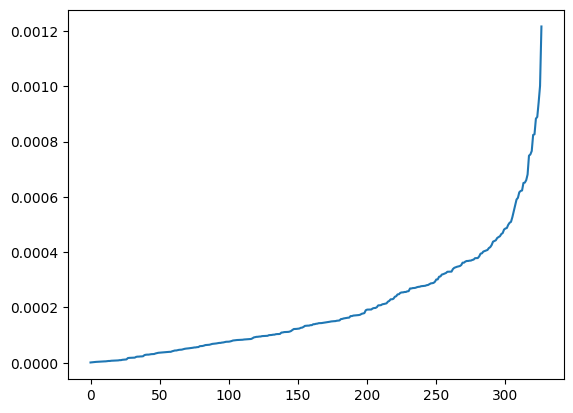

In [71]:
plt.plot(sorted_lst)

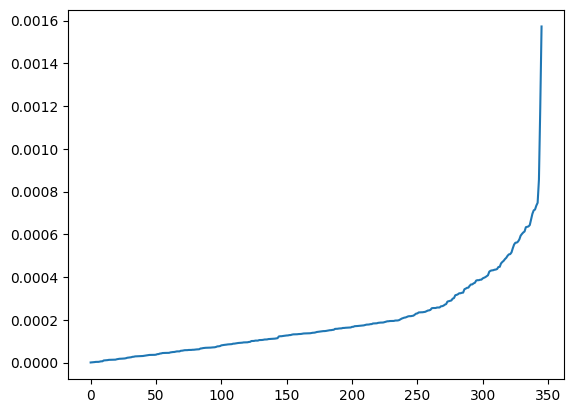

In [72]:
m=list(sol0[0])
sorted_lst = sorted(m)
plt.plot(sorted_lst)

In [73]:
count = np.sum(sol1 > 0.000282)
count

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0    82
dtype: int64

Ratio 0.59 is the best